# Final Plots 2?

This is after suggestions/discussion with Jess on Wed Aug 9th 2023

Trying synthesize the final plots for the paper from all the other previous notebooks 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 40

# update various fontsizes to match
params = {'figure.figsize': (20, 14),
          'legend.fontsize': 20,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 16,
          'xtick.minor.size': 13,
          'ytick.major.size': 16,
          'ytick.minor.size': 13}
plt.rcParams.update(params)

import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList
import glob

import seaborn as sns
pal = sns.color_palette("pastel")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

# ur gonna need this boi
import matplotlib as mpl

import statistics as stat

from lifelines import KaplanMeierFitter

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [2]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## Bringing in and Organizing all the Data Tables 

In [64]:
#Bring in all the COS-Holes fit data and modifying
cosholes_df = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/cosholes_df.csv')
cosholes_df

,galaxy,QSO,zgal,Vhelio [km/s],MBH,sigMBH,M*,Mhalo,SFR,vrel,...,wav,zsys,N,sigN,b,sigb,vel,sigvel,comp,uplim
0,NGC3489,J1101,0.002258,676.90,6.770,0.065,10.20,11.782755,-0.967,10.751189,...,1548.204,0.002230,13.403000,0.099000,35.700,11.549,2.357,7.816,1,1
1,NGC4026,J1159,0.003286,985.10,8.255,0.125,10.43,11.964435,-1.767,13.641094,...,1548.204,0.003300,13.697000,0.074000,80.715,17.306,-9.444,12.162,1,1
2,NGC4258,J1220,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.650000,0.050000,0.000,0.000,0.000,0.000,1,0
3,NGC4258,J1222,0.001494,461.08,7.577,0.030,10.88,12.522479,-0.080,0.000000,...,1550.781,0.001494,13.500000,0.050000,0.000,0.000,0.000,0.000,1,0
4,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,0.000000,...,1548.204,0.000000,14.311323,0.123487,0.000,0.000,0.000,0.000,2,1
5,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,166.647701,...,1548.204,0.000510,13.855000,0.052000,34.300,6.220,11.655,3.925,0,1
6,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,62.794963,...,1548.204,0.000810,13.652000,0.103000,10.925,4.852,-2.260,2.533,0,1
7,NGC4736,J1249,0.001027,307.80,6.830,0.123,10.62,12.154667,-0.061,29.956925,...,1548.204,0.001090,13.946000,0.044000,30.000,4.293,-11.070,2.849,0,1
8,NGC3414,J1051,0.004900,1469.80,8.400,0.071,10.79,12.377581,-1.047,150.546380,...,1548.204,0.004420,13.990000,0.057000,32.780,5.621,6.646,3.813,1,1
9,NGC3627,J1123,0.002430,721.00,6.920,0.048,10.84,12.455645,0.536,117.031587,...,1548.204,0.002750,14.012000,0.076000,85.000,17.787,-21.098,12.763,1,1


In [4]:
#DATA frame for just the upper limits 

up_ch = cosholes_df.loc[(cosholes_df['uplim'] == 0)]
#up_ch

#Df of just the sums for the whole data set (use this for everything but the relative velocity plot) with no uplims 

sum_ch = cosholes_df.loc[(cosholes_df['comp'] > 0) & (cosholes_df['uplim'] == 1)]
#sum_ch

#Df of all the components for the whole data set (use this for just the relative velocity plot) with no uplims 
com_ch = cosholes_df.loc[(cosholes_df['comp'] < 2) & (cosholes_df['uplim'] == 1)]
#com_ch

In [5]:
cos_sup = pd.concat([sum_ch, up_ch])
cos_sup = cos_sup.drop(['galaxy', 'zgal', 'Mhalo', 'SFR', 'vrel', 'line', 'wav', 'zsys', 'b', 'sigb', 'vel', 'sigvel', 'comp', 'Vhelio [km/s]'], axis=1)
cos_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1101,6.770,0.065,10.20,110.019140,273.43553,0.402359,13.403000,0.099000,1
1,J1159,8.255,0.125,10.43,37.385240,314.35077,0.118928,13.697000,0.074000,1
4,J1249,6.830,0.123,10.62,25.520224,363.76792,0.070155,14.311323,0.123487,1
8,J1051,8.400,0.071,10.79,40.499140,431.64653,0.093825,13.990000,0.057000,1
9,J1123,6.920,0.048,10.84,119.976000,458.29968,0.261785,14.012000,0.076000,1
10,J0246,8.140,0.090,10.50,55.657239,330.32571,0.168492,14.211000,0.053000,1
2,J1220,7.577,0.030,10.88,69.778997,482.42196,0.144643,13.650000,0.050000,0
3,J1222,7.577,0.030,10.88,130.305660,482.42196,0.270107,13.500000,0.050000,0
11,J1235,7.940,0.145,10.40,123.078500,308.12739,0.399440,13.380000,0.050000,0


In [65]:
cos_wsfr = pd.concat([sum_ch, up_ch])
cos_wsfr = cos_wsfr.drop(['galaxy', 'zgal', 'Mhalo', 'vrel', 'line', 'wav', 'zsys', 'b', 'sigb', 'vel', 'sigvel', 'comp', 'Vhelio [km/s]'], axis=1)
cos_wsfr

,QSO,MBH,sigMBH,M*,SFR,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1101,6.770,0.065,10.20,-0.967,110.019140,273.43553,0.402359,13.403000,0.099000,1
1,J1159,8.255,0.125,10.43,-1.767,37.385240,314.35077,0.118928,13.697000,0.074000,1
4,J1249,6.830,0.123,10.62,-0.061,25.520224,363.76792,0.070155,14.311323,0.123487,1
8,J1051,8.400,0.071,10.79,-1.047,40.499140,431.64653,0.093825,13.990000,0.057000,1
9,J1123,6.920,0.048,10.84,0.536,119.976000,458.29968,0.261785,14.012000,0.076000,1
10,J0246,8.140,0.090,10.50,0.766,55.657239,330.32571,0.168492,14.211000,0.053000,1
2,J1220,7.577,0.030,10.88,-0.080,69.778997,482.42196,0.144643,13.650000,0.050000,0
3,J1222,7.577,0.030,10.88,-0.080,130.305660,482.42196,0.270107,13.500000,0.050000,0
11,J1235,7.940,0.145,10.40,-1.988,123.078500,308.12739,0.399440,13.380000,0.050000,0


In [6]:
#M31 Data (Project AMIGA) Detections (and taking out the MS contaminations) 

amiga_2_det_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_det_sum.csv')
amiga_2_det_sum = amiga_2_det_sum.loc[(amiga_2_det_sum['sumlogN']!= 0)]
amiga_2_det_sum = amiga_2_det_sum.loc[amiga_2_det_sum['MS']==0]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
#making sure to use r200 as a substitute for since that is what we used 
amiga_m31_rvrir = 230 #kpc This is the value used for R200 in the paper? 

amiga_det_R = np.array(amiga_2_det_sum['Rad'])
amiga_det_RRvir = amiga_det_R/amiga_m31_rvrir

#amiga_2_det_sum

In [7]:
#M31 Data (Project AMIGA) non-detections (upper limits) and taking out the MS contamination
amiga_2_up_sum = pd.read_csv('/Users/samgarza/Documents/COS-Holes/notebooks/amiga_2_up_sum.csv')
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['sumlogN']!= 0)]
amiga_2_up_sum = amiga_2_up_sum.loc[(amiga_2_up_sum['MS']== 0)]

#Calculating the Project AMIGA Rproj/Rvir so that I can add to future plot 
amiga_up_R = np.array(amiga_2_up_sum['Rad'])
amiga_up_RRvir = amiga_up_R/amiga_m31_rvrir

#amiga_2_up_sum

In [8]:
#making arrays of AMIGA MBH and error so that I can add to df 

#dets 
MBH_amiga = np.full(11, 8.15)
sigMBH_amiga = np.full(11, 0.24)
mstar_amiga = np.full(11, 10.3)
rvir_amiga = np.full(11,230)
uplim = np.full(11,1)

#ups
MBH_amiga_up = np.full(12, 8.15)
sigMBH_amiga_up = np.full(12, 0.24)
mstar_amiga_up = np.full(12, 10.3)
rvir_amiga_up = np.full(12,230)
uplim_up = np.full(12,0)

In [9]:
amiga_det = amiga_2_det_sum.drop(['index', 'z', 'RAdeg', 'Decdeg', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

amiga_det['amiga_det_RRvir'] = amiga_det_RRvir.tolist()
amiga_det['MBH_amiga'] = MBH_amiga.tolist()
amiga_det['sigMBH_amiga'] = sigMBH_amiga.tolist()
amiga_det['mstar_amiga'] = mstar_amiga.tolist()
amiga_det['rvir_amiga'] = rvir_amiga.tolist()
amiga_det['uplim'] = uplim.tolist()

amiga_det = amiga_det.rename(columns={'QSO': 'QSO', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN', 
                                      'amiga_det_RRvir': 'Rproj/Rvir', 'MBH_amiga': 'MBH', 'sigMBH_amiga': 'sigMBH', 'mstar_amiga': 'M*', 
                                     'rvir_amiga': 'Rvir','uplim': 'uplim'})

amiga_det = amiga_det.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

#amiga_det
amiga_det = amiga_det.loc[(amiga_det['Rproj/Rvir'] <= 0.8)]

In [10]:
#This is for the litertaure info table 
d_amiga_det = amiga_2_det_sum.drop(['index', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

d_amiga_det['amiga_det_RRvir'] = amiga_det_RRvir.tolist()
d_amiga_det['MBH_amiga'] = MBH_amiga.tolist()
d_amiga_det['sigMBH_amiga'] = sigMBH_amiga.tolist()
d_amiga_det['mstar_amiga'] = mstar_amiga.tolist()
d_amiga_det['rvir_amiga'] = rvir_amiga.tolist()
d_amiga_det['uplim'] = uplim.tolist()

d_amiga_det = d_amiga_det.rename(columns={'QSO': 'QSO', 'z':'z', 'RAdeg':'RA', 'Decdeg':'Dec', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN', 
                                      'amiga_det_RRvir': 'Rproj/Rvir', 'MBH_amiga': 'MBH', 'sigMBH_amiga': 'sigMBH', 'mstar_amiga': 'M*', 
                                     'rvir_amiga': 'Rvir','uplim': 'uplim'})

d_amiga_det
#d_amiga_det = d_amiga_det.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

#amiga_det
d_amiga_det = d_amiga_det.loc[(d_amiga_det['Rproj'] <= 150)]

In [11]:
np.mean(amiga_det['N'])

13.4875

In [13]:
amiga_up = amiga_2_up_sum.drop(['index', 'z', 'RAdeg', 'Decdeg', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

amiga_up['amiga_up_RRvir'] = amiga_up_RRvir.tolist()
amiga_up['MBH_amiga_up'] = MBH_amiga_up.tolist()
amiga_up['sigMBH_amiga_up'] = sigMBH_amiga_up.tolist()
amiga_up['mstar_amiga_up'] = mstar_amiga_up.tolist()
amiga_up['rvir_amiga_up'] = rvir_amiga_up.tolist()
amiga_up['uplim_up'] = uplim_up.tolist()

amiga_up = amiga_up.rename(columns={'QSO': 'QSO', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN',
                                      'amiga_up_RRvir': 'Rproj/Rvir', 'MBH_amiga_up': 'MBH', 'sigMBH_amiga_up': 'sigMBH', 
                                    'mstar_amiga_up': 'M*', 'rvir_amiga_up': 'Rvir', 'uplim_up': 'uplim'})

amiga_up = amiga_up.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

#amiga_up
amiga_up = amiga_up.loc[(amiga_up['Rproj/Rvir'] <= 0.8)]

In [14]:
np.mean(amiga_up['N'])

13.014

In [15]:
#This is for the literature table 

d_amiga_up = amiga_2_up_sum.drop(['index', 'ion', 'b_Vel', 'B_Vel', 'Vel', 'e_V', 'E_logN', 'e_logN', 'MS', 'sumlogN', 'f_logN'],axis=1)

d_amiga_up['amiga_up_RRvir'] = amiga_up_RRvir.tolist()
d_amiga_up['MBH_amiga_up'] = MBH_amiga_up.tolist()
d_amiga_up['sigMBH_amiga_up'] = sigMBH_amiga_up.tolist()
d_amiga_up['mstar_amiga_up'] = mstar_amiga_up.tolist()
d_amiga_up['rvir_amiga_up'] = rvir_amiga_up.tolist()
d_amiga_up['uplim_up'] = uplim_up.tolist()

d_amiga_up = d_amiga_up.rename(columns={'QSO': 'QSO', 'z':'z', 'RAdeg':'RA', 'Decdeg':'Dec', 'Rad': 'Rproj', 'logN': 'N', 'sum_elogN': 'sigN',
                                      'amiga_up_RRvir': 'Rproj/Rvir', 'MBH_amiga_up': 'MBH', 'sigMBH_amiga_up': 'sigMBH', 
                                    'mstar_amiga_up': 'M*', 'rvir_amiga_up': 'Rvir', 'uplim_up': 'uplim'})

#d_amiga_up = amiga_up.iloc[:,[0,5,6,7,1,8,4,2,3,9]]

#amiga_up
d_amiga_up = d_amiga_up.loc[(d_amiga_up['Rproj'] <= 150)]
d_amiga_up

,QSO,z,RA,Dec,Rproj,N,sigN,Rproj/Rvir,MBH,sigMBH,M*,Rvir,uplim
1,RX_J0043.6+3725,0.080,10.927,37.422,50.5,12.92,0.30,0.219565,8.15,0.24,10.3,230,0
5,RXS_J0118.8+3836,0.216,19.706,38.606,97.2,12.90,0.42,0.422609,8.15,0.24,10.3,230,0
7,RX_J0028.1+3103,0.500,7.045,31.063,139.1,13.11,0.42,0.604783,8.15,0.24,10.3,230,0


In [16]:
amiga_sup = pd.concat([amiga_det, amiga_up])
amiga_sup = amiga_sup.loc[(amiga_sup['Rproj'] <= 150)]
#amiga_sup = amiga_sup.loc[(amiga_sup['Rproj/Rvir'] <= 0.8)]
amiga_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
3,HS0033+4300,8.15,0.24,10.3,30.5,230,0.132609,14.10,0.050000,1
4,HS0058+4213,8.15,0.24,10.3,48.6,230,0.211304,13.33,0.183848,1
6,RX_J0043.6+3725,8.15,0.24,10.3,50.5,230,0.219565,13.85,0.030000,1
7,Zw535.012,8.15,0.24,10.3,59.7,230,0.259565,12.99,0.300167,1
9,RX_J0050.8+3536,8.15,0.24,10.3,77.1,230,0.335217,13.45,0.070000,1
10,IRAS_F00040+4325,8.15,0.24,10.3,93.0,230,0.404348,13.23,0.106301,1
12,MRK352,8.15,0.24,10.3,131.7,230,0.572609,13.50,0.152971,1
1,RX_J0043.6+3725,8.15,0.24,10.3,50.5,230,0.219565,12.92,0.300000,0
5,RXS_J0118.8+3836,8.15,0.24,10.3,97.2,230,0.422609,12.90,0.420000,0
7,RX_J0028.1+3103,8.15,0.24,10.3,139.1,230,0.604783,13.11,0.420000,0


In [17]:
#This is for the litertaure information table 
d_amiga_sup = pd.concat([d_amiga_det, d_amiga_up])
#amiga_sup = amiga_sup.loc[(amiga_sup['Rproj/Rvir'] <= 0.8)]
d_amiga_sup

,QSO,z,RA,Dec,Rproj,N,sigN,Rproj/Rvir,MBH,sigMBH,M*,Rvir,uplim
3,HS0033+4300,0.120,9.096,43.278,30.5,14.10,0.050000,0.132609,8.15,0.24,10.3,230,1
4,HS0058+4213,0.190,15.380,42.493,48.6,13.33,0.183848,0.211304,8.15,0.24,10.3,230,1
6,RX_J0043.6+3725,0.080,10.927,37.422,50.5,13.85,0.030000,0.219565,8.15,0.24,10.3,230,1
7,Zw535.012,0.048,9.087,45.665,59.7,12.99,0.300167,0.259565,8.15,0.24,10.3,230,1
9,RX_J0050.8+3536,0.058,12.711,35.612,77.1,13.45,0.070000,0.335217,8.15,0.24,10.3,230,1
10,IRAS_F00040+4325,0.163,1.652,43.708,93.0,13.23,0.106301,0.404348,8.15,0.24,10.3,230,1
12,MRK352,0.015,14.972,31.827,131.7,13.50,0.152971,0.572609,8.15,0.24,10.3,230,1
1,RX_J0043.6+3725,0.080,10.927,37.422,50.5,12.92,0.300000,0.219565,8.15,0.24,10.3,230,0
5,RXS_J0118.8+3836,0.216,19.706,38.606,97.2,12.90,0.420000,0.422609,8.15,0.24,10.3,230,0
7,RX_J0028.1+3103,0.500,7.045,31.063,139.1,13.11,0.420000,0.604783,8.15,0.24,10.3,230,0


In [18]:
w = np.array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25])

In [19]:
amiga_sup_w = amiga_sup
amiga_sup_w['w'] = w.tolist()

In [20]:
amiga_sup_w

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim,w
3,HS0033+4300,8.15,0.24,10.3,30.5,230,0.132609,14.10,0.050000,1,0.75
4,HS0058+4213,8.15,0.24,10.3,48.6,230,0.211304,13.33,0.183848,1,0.75
6,RX_J0043.6+3725,8.15,0.24,10.3,50.5,230,0.219565,13.85,0.030000,1,0.75
7,Zw535.012,8.15,0.24,10.3,59.7,230,0.259565,12.99,0.300167,1,0.75
9,RX_J0050.8+3536,8.15,0.24,10.3,77.1,230,0.335217,13.45,0.070000,1,0.75
10,IRAS_F00040+4325,8.15,0.24,10.3,93.0,230,0.404348,13.23,0.106301,1,0.75
12,MRK352,8.15,0.24,10.3,131.7,230,0.572609,13.50,0.152971,1,0.75
1,RX_J0043.6+3725,8.15,0.24,10.3,50.5,230,0.219565,12.92,0.300000,0,0.75
5,RXS_J0118.8+3836,8.15,0.24,10.3,97.2,230,0.422609,12.90,0.420000,0,0.25
7,RX_J0028.1+3103,8.15,0.24,10.3,139.1,230,0.604783,13.11,0.420000,0,0.25


In [21]:
np.average(amiga_sup_w['N'], weights = amiga_sup_w['w'])

13.38923076923077

In [22]:
np.average(amiga_sup_w['sigN'], weights = amiga_sup_w['w'])

0.16999458773076923

In [23]:
np.average(amiga_sup_w['Rproj/Rvir'])

0.33821739130434786

In [24]:
np.average(amiga_sup_w['Rproj'])

77.78999999999999

In [25]:
#Mean Project AMIGA Literature Point    

amiga = {'QSO': ['M31'],
            'MBH': [8.15],
            'sigMBH': [0.24],
            'M*': [10.3], 
            'Rproj': [77.79], 
            'Rvir': [230],
               'Rproj/Rvir': [0.33],
               'N': [13.39],
               'sigN': [0.17], 
           'uplim': [1]}
AMIGA = pd.DataFrame(data=amiga)

In [26]:
#Borthakur 2013 Data
#https://iopscience.iop.org/article/10.1088/0004-637X/768/1/18/pdf

borthakur = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/borthakur_2013_err.csv", sep=",")   
borthakur.sort_values('det', inplace=True)
#borthakur

#remove the zero value in the df 
borthakur_no_zero = borthakur.drop(labels=12, axis=0)
#print(borthakur_no_zero)

########################################################

#Bordoloi 2014 Data 
#https://iopscience.iop.org/article/10.1088/0004-637X/796/2/136/pdf

bordoloi = pd.read_csv("/Users/samgarza/Documents/COS-Holes/notebooks/bordoloi_2014_CIV_err.csv", sep=",") 
bordoloi.sort_values('det', inplace=True)
#bordoloi

########################################################

#COS-Halos    

coshalos = {'QSO': ['J0910', 'J1619'],
            'sigMBH': [0.5, 0.5],
            'M*': [10.61, 10.10], 
            'Rproj': [112, 97], 
            'Rvir': [329, 249],
               'Rproj/Rvir': [0.34, 0.39],
               'N': [14.10, 13.90],
               'sigN': [0.09, 0.03], 
           'uplim': [1,1]}
COSHALOS = pd.DataFrame(data=coshalos)

### Setting up Stellar Mass Bins 

Since we are still seeing a null result I want to investigate how the stellar mass may be impacting the sample so will split the larger sample into a stellar mass bin that only has values between 10^10-11 and use data from 0-150 kpc (since that is where we see the most "consistency")

In [27]:
####### BORTHAKUR ######### => Only has high stellar mass bin values 

borthakur_less150 = borthakur_no_zero.loc[(borthakur_no_zero['rhokpc[i]'] <= 150)]
#borthakur_less150
borthakur_high = borthakur_less150.loc[(borthakur_less150['mstar[i]'] >= 10) & (borthakur_less150['mstar[i]'] <= 11)]
borthakur_high

,galname[i],mstar[i],alog10(mhalo[i]),rvir[i],rhokpc[i],rhokpc[i]/rvir[i],logNCIV[i],err,det
16,J154527.12+484642.2,10.50,12.029020,330.32571,64.7,0.195867,13.79,0.05,0
13,J132150.89+033034.1,10.81,12.408067,441.86569,140.2,0.317291,14.06,0.05,0
8,J102846.43+391842.9,10.50,12.029020,330.32571,88.7,0.268523,14.65,0.04,1
14,J140502.20+470525.9,10.43,11.964435,314.35077,146.9,0.467312,14.25,0.08,1


In [28]:
####### BORDOLOI ######### 

bordoloi_less150 = bordoloi.loc[(bordoloi['R[kpc]'] <= 150) & (bordoloi['logM*'] >= 9) ]
#bordoloi_less150

#separating into the stellar mass sample: 10-11
#bordoloi_low = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 9) & (bordoloi_less150['logM*'] < 10)]
    #Due to the new stellar mass bin idea, we don't need the bordoloi low
bordoloi_high = bordoloi_less150.loc[(bordoloi_less150['logM*'] >= 10.0) & (bordoloi_less150['logM*'] <= 11.0)]

bordoloi_high

,QSO,logNCIV,err,det,logM*,R[kpc],Rvir[kpc],R/Rvir
25,J1211+3657,13.17,0.05,0,10.1,90,272,0.330882
26,J1121+0325,13.45,0.05,0,10.1,89,277,0.321300
1,J09525+4535,13.56,0.06,1,10.0,95,259,0.366795
15,PG1202+281,13.58,0.10,1,10.0,92,254,0.362205
12,J0959+0503,14.69,0.05,2,10.0,14,247,0.056680


### Using the Velocity Dispersions of the Galaxy to calculate the MBH for each of our literature values

In [29]:
gals = fits.open('/Users/samgarza/Dropbox/COS-Holes/ArchivalData/gal_info_dr7_v5_2.fit')
gals.info()

Filename: /Users/samgarza/Dropbox/COS-Holes/ArchivalData/gal_info_dr7_v5_2.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     67   927552R x 25C   [I, J, I, 5I, E, E, 5E, I, I, 19A, 6A, 21A, E, E, I, E, E, E, E, E, E, 3E, 3E, 5E, 12A]   


In [30]:
gal_data = gals[1].data

In [31]:
#Values that I need to search for the vdisps for the specific galaxy/qso using from literature 

#BORDOLOI VALUES 
pids = np.array([2105, 511, 833, 2227, 995])
mjds = np.array([53472, 52636, 52314, 53820, 52731])
fids = np.array([407, 449, 104, 491, 208])

#BORTHAKUR VALUES 

pids_borth = np.array([1167, 526, 1430, 1285])
mjds_borth = np.array([52738, 52312, 53002, 52723])
fids_borth = np.array([638, 529, 237, 37])

In [32]:
#For Bordoloi
vdisps = []
vdisps_err = []

for i in range(len(pids)): 
    #Plate ID
    mask = gal_data.PLATEID == pids[i]
    check = gal_data[mask]

    #MJD
    mask2 = check.MJD == mjds[i]
    check = check[mask2]

    #FIBERID
    mask3 = check.FIBERID == fids[i]
    test = check[mask3]
    print(test.shape)
    
    print(f'V_DISP: {test.V_DISP}, V_DISP_ERR:{test.V_DISP_ERR}')
    
    vdisps.append(test.V_DISP)
    vdisps_err.append(test.V_DISP_ERR)
    
vdisps = np.array(vdisps)
vdisps = vdisps.reshape(5,)
#vdisps

vdisps_err = np.array(vdisps_err)
vdisps_err = vdisps_err.reshape(5,)
#vdisps_err

(1,)
V_DISP: [57.136898], V_DISP_ERR:[13.070264]
(1,)
V_DISP: [41.15367], V_DISP_ERR:[9.7062435]
(1,)
V_DISP: [43.57293], V_DISP_ERR:[7.5054946]
(1,)
V_DISP: [33.40527], V_DISP_ERR:[16.83185]
(1,)
V_DISP: [77.021416], V_DISP_ERR:[17.392845]


In [33]:
#For Borthakur
vdisps_borth = []
vdisps_err_borth = []

for i in range(len(pids_borth)): 
    #Plate ID
    mask = gal_data.PLATEID == pids_borth[i]
    check = gal_data[mask]

    #MJD
    mask2 = check.MJD == mjds_borth[i]
    check = check[mask2]

    #FIBERID
    mask3 = check.FIBERID == fids_borth[i]
    test = check[mask3]
    print(test.shape)
    
    print(f'V_DISP: {test.V_DISP}, V_DISP_ERR:{test.V_DISP_ERR}')
    
    vdisps_borth.append(test.V_DISP)
    vdisps_err_borth.append(test.V_DISP_ERR)
    
vdisps_borth = np.array(vdisps_borth)
vdisps_borth = vdisps_borth.reshape(4,)
#vdisps

vdisps_err_borth = np.array(vdisps_err_borth)
vdisps_err_borth = vdisps_err_borth.reshape(4,)
#vdisps_err

(1,)
V_DISP: [76.28716], V_DISP_ERR:[17.076445]
(1,)
V_DISP: [148.91199], V_DISP_ERR:[7.8888116]
(1,)
V_DISP: [121.198685], V_DISP_ERR:[18.669765]
(1,)
V_DISP: [134.5503], V_DISP_ERR:[24.878817]


#### Using Equation (7) from Piotrowska et al 2022 to take the velocity dispersions that we just found and get the MBH 
(https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.1052P/abstract)

In [34]:
#BORDOLOI MBH AND ERROR
logMBH_bord = (5.246 * np.log10(vdisps)) - 3.77 #epsilon = 0.417
#logMBH_bord

logMBH_bord_err_down = (5.246 * np.log10(vdisps - vdisps_err)) - 3.77 #epsilon = 0.417
#logMBH_bord_err_down
logMBH_bord_err1 = logMBH_bord-logMBH_bord_err_down

logMBH_bord_err_up = (5.246 * np.log10(vdisps + vdisps_err)) - 3.77 #epsilon = 0.417
#logMBH_bord_err_up
logMBH_bord_err2 = np.abs(logMBH_bord-logMBH_bord_err_up)

logMBH_bord_err = (logMBH_bord_err1 + logMBH_bord_err2)/2
logMBH_bord_err

array([0.5305581 , 0.54765725, 0.3963933 , 1.2632699 , 0.52350664],
      dtype=float32)

In [35]:
#BORDOLOI MBH AND ERROR
logMBH_borth = (5.246 * np.log10(vdisps_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth

logMBH_borth_err_down = (5.246 * np.log10(vdisps_borth - vdisps_err_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth_err_down
logMBH_borth_err1 = logMBH_borth-logMBH_borth_err_down

logMBH_borth_err_up = (5.246 * np.log10(vdisps_borth + vdisps_err_borth)) - 3.77 #epsilon = 0.417
#logMBH_borth_err_up
logMBH_borth_err2 = np.abs(logMBH_borth-logMBH_borth_err_up)

logMBH_borth_err = (logMBH_borth_err1+logMBH_borth_err2)/2
logMBH_borth_err

array([0.51876974, 0.12080908, 0.35377312, 0.4261694 ], dtype=float32)

In [36]:
#COS-Halos MBH

vdisp_halos = np.array([154, 78])

logMBH_halo = (5.246 * np.log10(vdisp_halos)) - 3.77 #epsilon = 0.417
logMBH_halo

array([7.7057337 , 6.15592829])

In [37]:
#Adding the mbhs to the literature tables (that have been shortened due to stellar mass) 

#For the sum values 
mini_borth= {'MBH': logMBH_borth,
             'MBH_err': logMBH_borth_err}
mini_borth = pd.DataFrame(data=mini_borth)
#mini_borth

In [38]:
#For the sum values 
mini_bord= {'MBH': logMBH_bord,
             'MBH_err': logMBH_bord_err}
mini_bord = pd.DataFrame(data=mini_bord)
#mini_bord

In [39]:
#All the data for Borthakur
borthakur_new = pd.concat([borthakur_high.reset_index(drop=True), mini_borth], axis=1)
#borthakur_new

borth_sup = borthakur_new.drop(['alog10(mhalo[i])'], axis=1)
borth_sup = borth_sup.rename(columns={"galname[i]": "QSO", "MBH": "MBH", "MBH_err": "sigMBH","mstar[i]": "M*",
                         "rhokpc[i]": "Rproj", "rvir[i]": "Rvir", "rhokpc[i]/rvir[i]": "Rproj/Rvir",
                         "logNCIV[i]": "N", "err": "sigN", "det": "uplim",})
borth_sup = borth_sup.iloc[:,[0,8,9,1,3,2,4,5,6,7]]
borth_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J154527.12+484642.2,6.105340,0.518770,10.50,64.7,330.32571,0.195867,13.79,0.05,0
1,J132150.89+033034.1,7.629189,0.120809,10.81,140.2,441.86569,0.317291,14.06,0.05,0
2,J102846.43+391842.9,7.160030,0.353773,10.50,88.7,330.32571,0.268523,14.65,0.04,1
3,J140502.20+470525.9,7.398128,0.426169,10.43,146.9,314.35077,0.467312,14.25,0.08,1


In [40]:
#Split into det and non det 

borth_det = borth_sup.loc[(borthakur_new['det'] == 1)]
#borth_det

borth_uplim = borth_sup.loc[(borthakur_new['det'] == 0)]
#borth_uplim

In [41]:
#All the data for Bordoloi
bordoloi_new = pd.concat([bordoloi_high.reset_index(drop=True), mini_bord], axis=1)
#bordoloi_new

bord_sup = bordoloi_new.rename(columns={"QSO": "QSO", "logNCIV": "N", "err": "sigN","det": "uplim",
                         "logM*": "M*", "R[kpc]": "Rproj", "Rvir[kpc]": "Rvir",
                         "R/Rvir": "Rproj/Rvir", "MBH": "MBH", "MBH_err": "sigMBH",})
bord_sup = bord_sup.iloc[:,[0,8,9,4,5,6,7,1,2,3]]
bord_sup

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1211+3657,5.446784,0.530558,10.1,90,272,0.330882,13.17,0.05,0
1,J1121+0325,4.699188,0.547657,10.1,89,277,0.321300,13.45,0.05,0
2,J09525+4535,4.829331,0.396393,10.0,95,259,0.366795,13.56,0.06,1
3,PG1202+281,4.223933,1.263270,10.0,92,254,0.362205,13.58,0.10,1
4,J0959+0503,6.127163,0.523507,10.0,14,247,0.056680,14.69,0.05,2


In [42]:
bord_det = bord_sup.loc[(bordoloi_new['det'] == 1)]
#bord_det

bord_uplim = bord_sup.loc[(bordoloi_new['det'] == 0)]
#bord_uplim

bord_lolim = bord_sup.loc[(bordoloi_new['det'] == 2)]
#bord_lolim

In [43]:
COSHALOS.insert(loc = 1,
          column = 'MBH',
          value = logMBH_halo)
COSHALOS

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J0910,7.705734,0.5,10.61,112,329,0.34,14.1,0.09,1
1,J1619,6.155928,0.5,10.10,97,249,0.39,13.9,0.03,1


In [44]:
coslit = pd.concat([cos_sup, borth_sup, bord_sup, COSHALOS, AMIGA])

coslit = coslit.reset_index(drop=True)

coslit

,QSO,MBH,sigMBH,M*,Rproj,Rvir,Rproj/Rvir,N,sigN,uplim
0,J1101,6.770000,0.065000,10.20,110.019140,273.43553,0.402359,13.403000,0.099000,1
1,J1159,8.255000,0.125000,10.43,37.385240,314.35077,0.118928,13.697000,0.074000,1
2,J1249,6.830000,0.123000,10.62,25.520224,363.76792,0.070155,14.311323,0.123487,1
3,J1051,8.400000,0.071000,10.79,40.499140,431.64653,0.093825,13.990000,0.057000,1
4,J1123,6.920000,0.048000,10.84,119.976000,458.29968,0.261785,14.012000,0.076000,1
5,J0246,8.140000,0.090000,10.50,55.657239,330.32571,0.168492,14.211000,0.053000,1
6,J1220,7.577000,0.030000,10.88,69.778997,482.42196,0.144643,13.650000,0.050000,0
7,J1222,7.577000,0.030000,10.88,130.305660,482.42196,0.270107,13.500000,0.050000,0
8,J1235,7.940000,0.145000,10.40,123.078500,308.12739,0.399440,13.380000,0.050000,0
9,J154527.12+484642.2,6.105340,0.518770,10.50,64.700000,330.32571,0.195867,13.790000,0.050000,0


In [ ]:
import os

#coslit.to_csv('/Users/samgarza/Documents/COS-Holes/notebooks/coslit.csv')  

In [45]:
coslit_det = coslit.loc[(coslit['uplim'] == 1)]

coslit_uplim = coslit.loc[(coslit['uplim'] == 0)]

coslit_lolim = coslit.loc[(coslit['uplim'] == 2)]

In [46]:
coslit_det = coslit_det.reset_index(drop=True)
#coslit_det

In [47]:
coslit_uplim = coslit_uplim.reset_index(drop=True)
coslit_lolim = coslit_lolim.reset_index(drop=True)

## Okay finally Done getting the data all situated and now we can focus on the plots 

### Random plot for showing cuts

In [48]:
from mycolorpy import colorlist as mcp
#For the MBH 
color1=mcp.gen_color(cmap="winter",n=5)
print(color1)

['#0000ff', '#0040df', '#0080bf', '#00c09f', '#00ff80']


In [49]:
low_mask, high_mask = (cosholes_df["MBH"] <= 7), (cosholes_df["MBH"] > 7)
low_mask_rr, high_mask_rr = (cosholes_df["Rproj/Rvir"] <= 0.3), (cosholes_df["Rproj/Rvir"] > 0.3)

#Creating masks for literature 

low_mask_lit, high_mask_lit = (coslit["MBH"] <= 7), (coslit["MBH"] > 7)
low_mask_rr_lit, high_mask_rr_lit = (cosholes_df["Rproj/Rvir"] <= 0.3), (cosholes_df["Rproj/Rvir"] > 0.3)

#Creating masks for literature individually bc the whole df wants to be a dick right now 

low_mask_borth, high_mask_borth = (borthakur_new["MBH"] <= 7), (borthakur_new["MBH"] > 7)
low_mask_bord, high_mask_bord = (bordoloi_new["MBH"] <= 7), (bordoloi_new["MBH"] > 7)
low_mask_halos, high_mask_halos = (COSHALOS["MBH"] <= 7), (COSHALOS["MBH"] > 7)

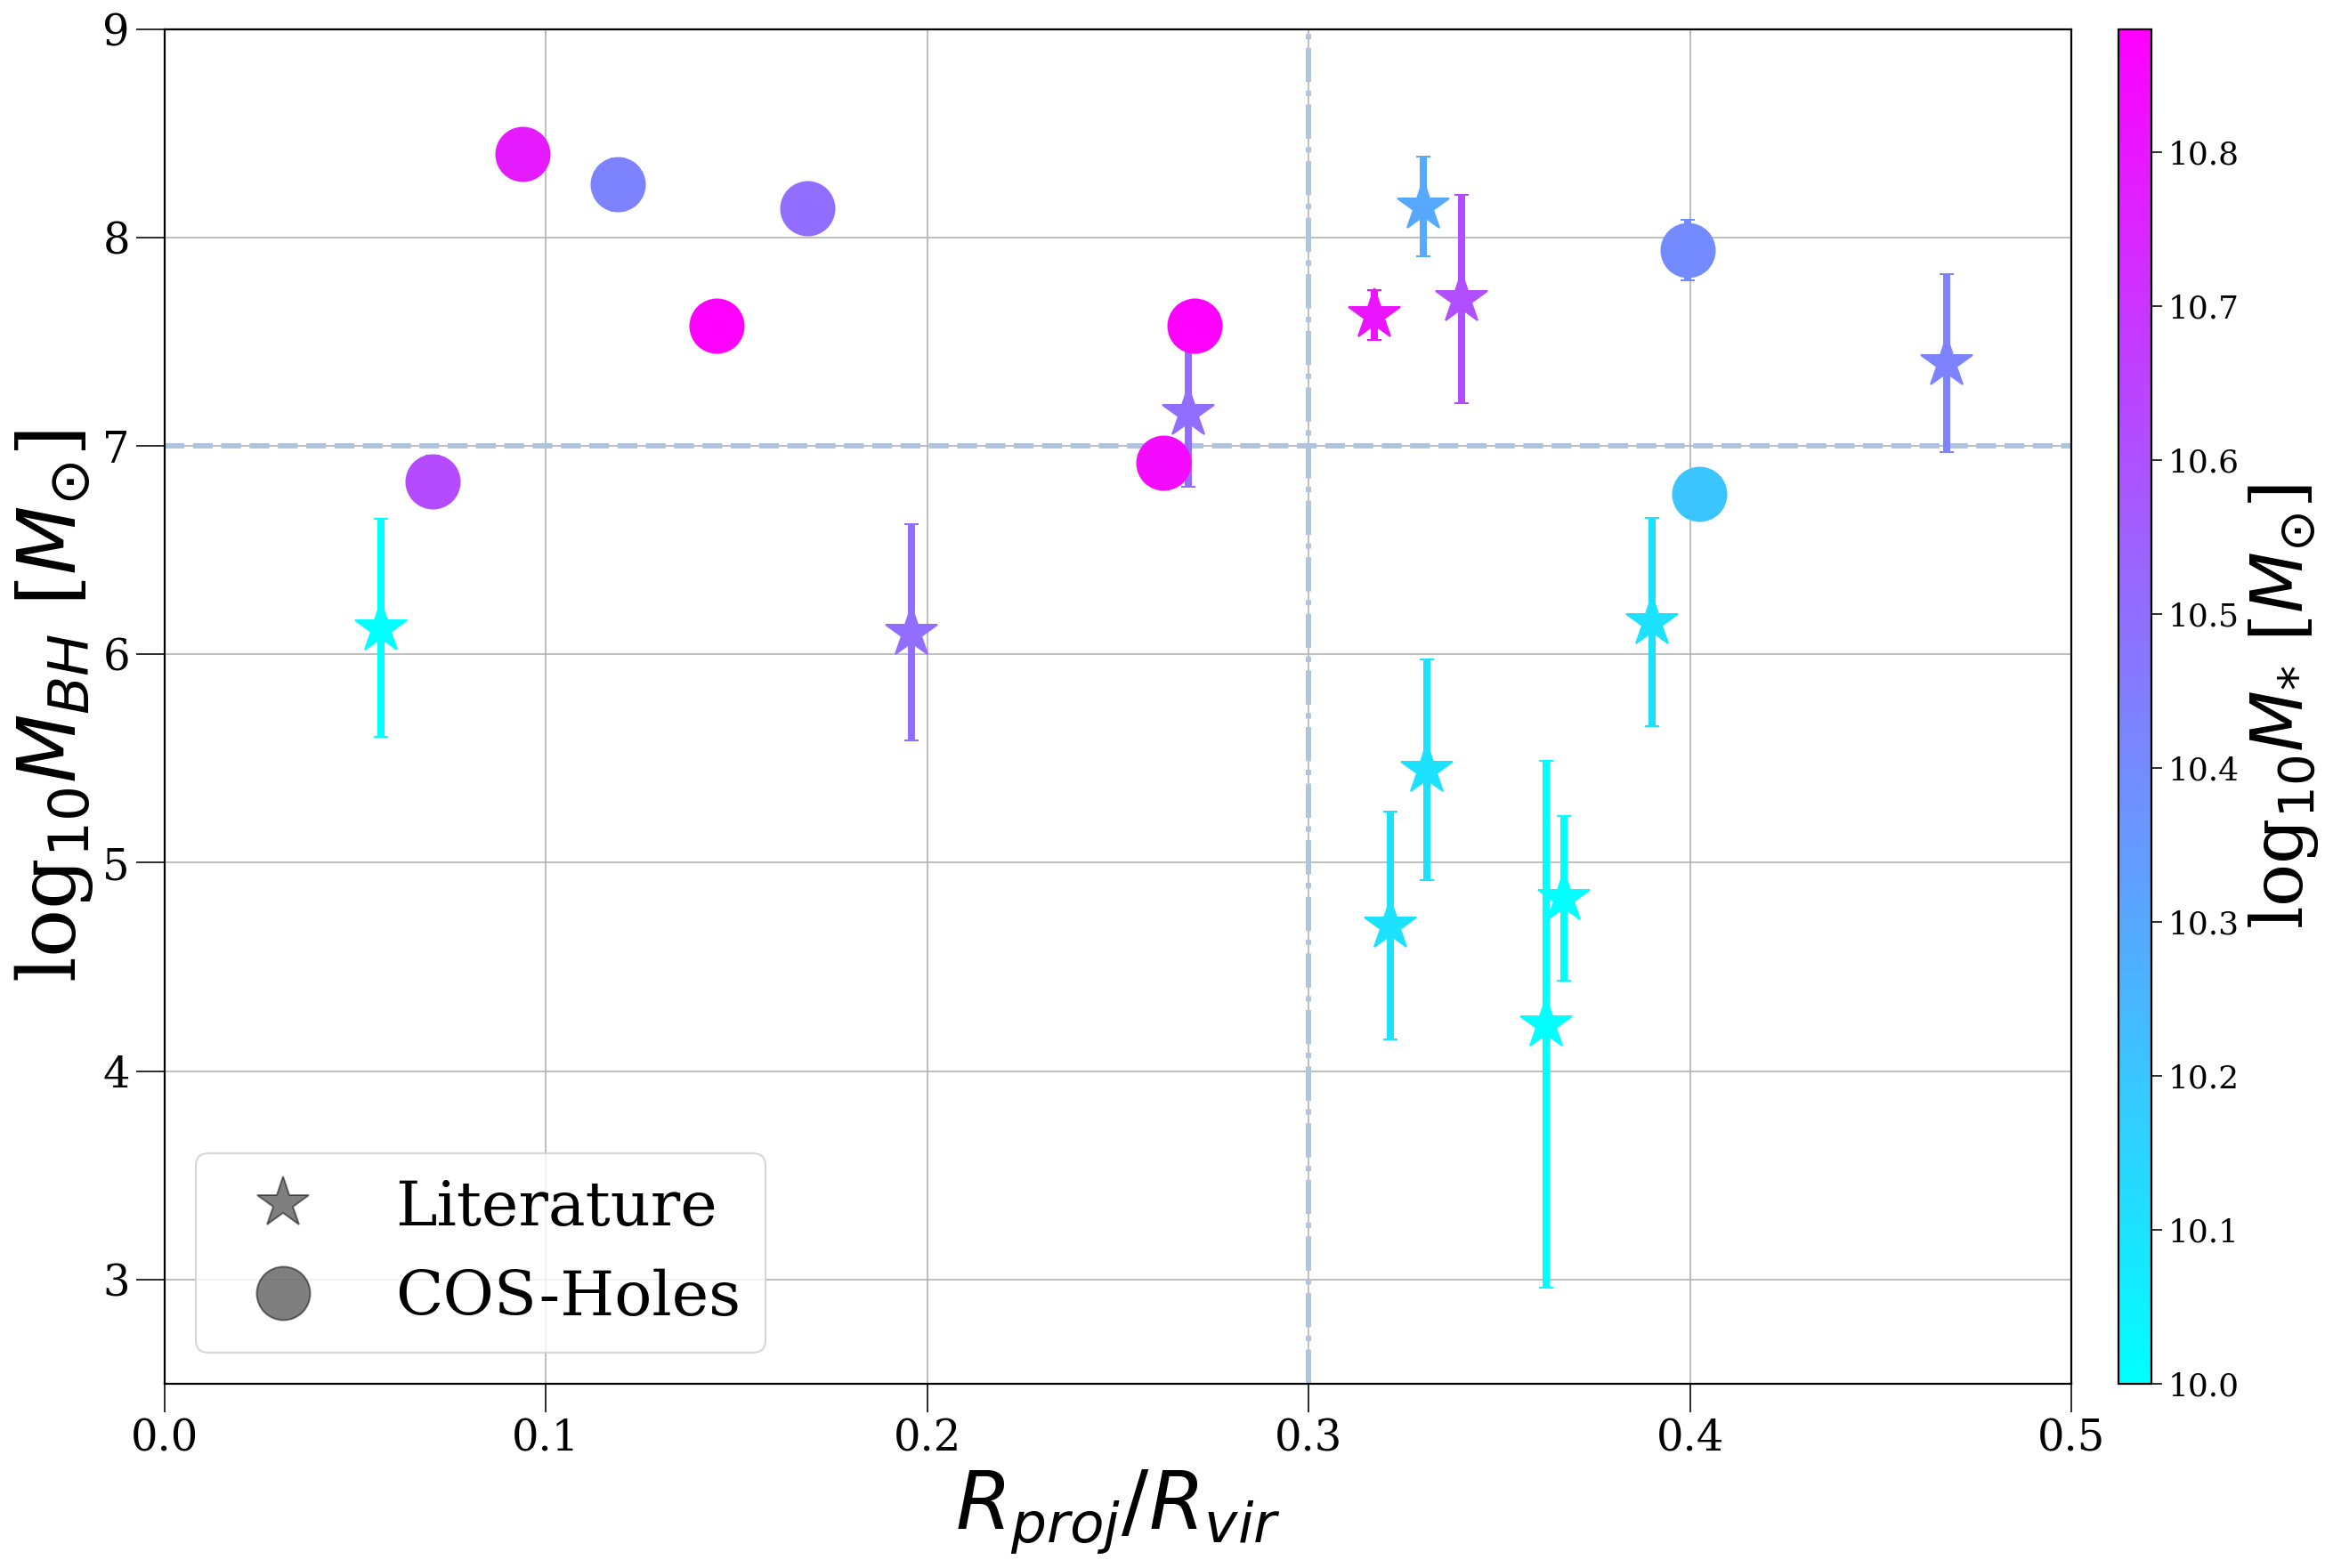

In [128]:
# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

UL = np.array(coslit['uplim'])
has_UL = UL < 1

# Set a grid on your figure so you can define the color bar axis
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
cool = plt.cm.get_cmap('cool')

#c = np.asarray(coslit['MBH'])
c = np.asarray(coslit['M*'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
rr_arr = np.array(coslit['Rproj/Rvir'])
mbh_arr = np.array(coslit['MBH'])
#sigN_arr = np.array(coslit['sigN'])
sigmbh_arr = np.array(coslit['sigMBH'])
uplim_arr = np.array(coslit['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o', 
                '*', '*', '*', '*', 
               '*', '*', '*', '*', '*', 
               '*', '*',
               '*']


#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Literature', alpha=0.5)
#plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
#plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
#plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)

plot.axhline(7, c='lightsteelblue', ls='--', lw=3)
plot.axvline(0.3, c='lightsteelblue', ls='-.', lw=3)

        
for i in range(len(mbh_arr)): 
    plot.errorbar(rr_arr[i],mbh_arr[i], 
                yerr=sigmbh_arr[i],
                capsize = 4, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=4)
    
# I changed some of your sizes cause they looked too big with my code ig

# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'log$_{10}M_{*}$ [$M_{\odot}$]', size=40)

# Your other stylings from above:
plot.legend(loc=3, fontsize=35) # Theres no labels for your legend but ill leave it
plot.set_ylabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=45)
plot.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
plot.set_ylim([2.5, 9])
plot.set_xlim([0, 0.5])
plot.grid(True)
#plt.tight_layout()
plt.show()

### IDEAS for FIG 3

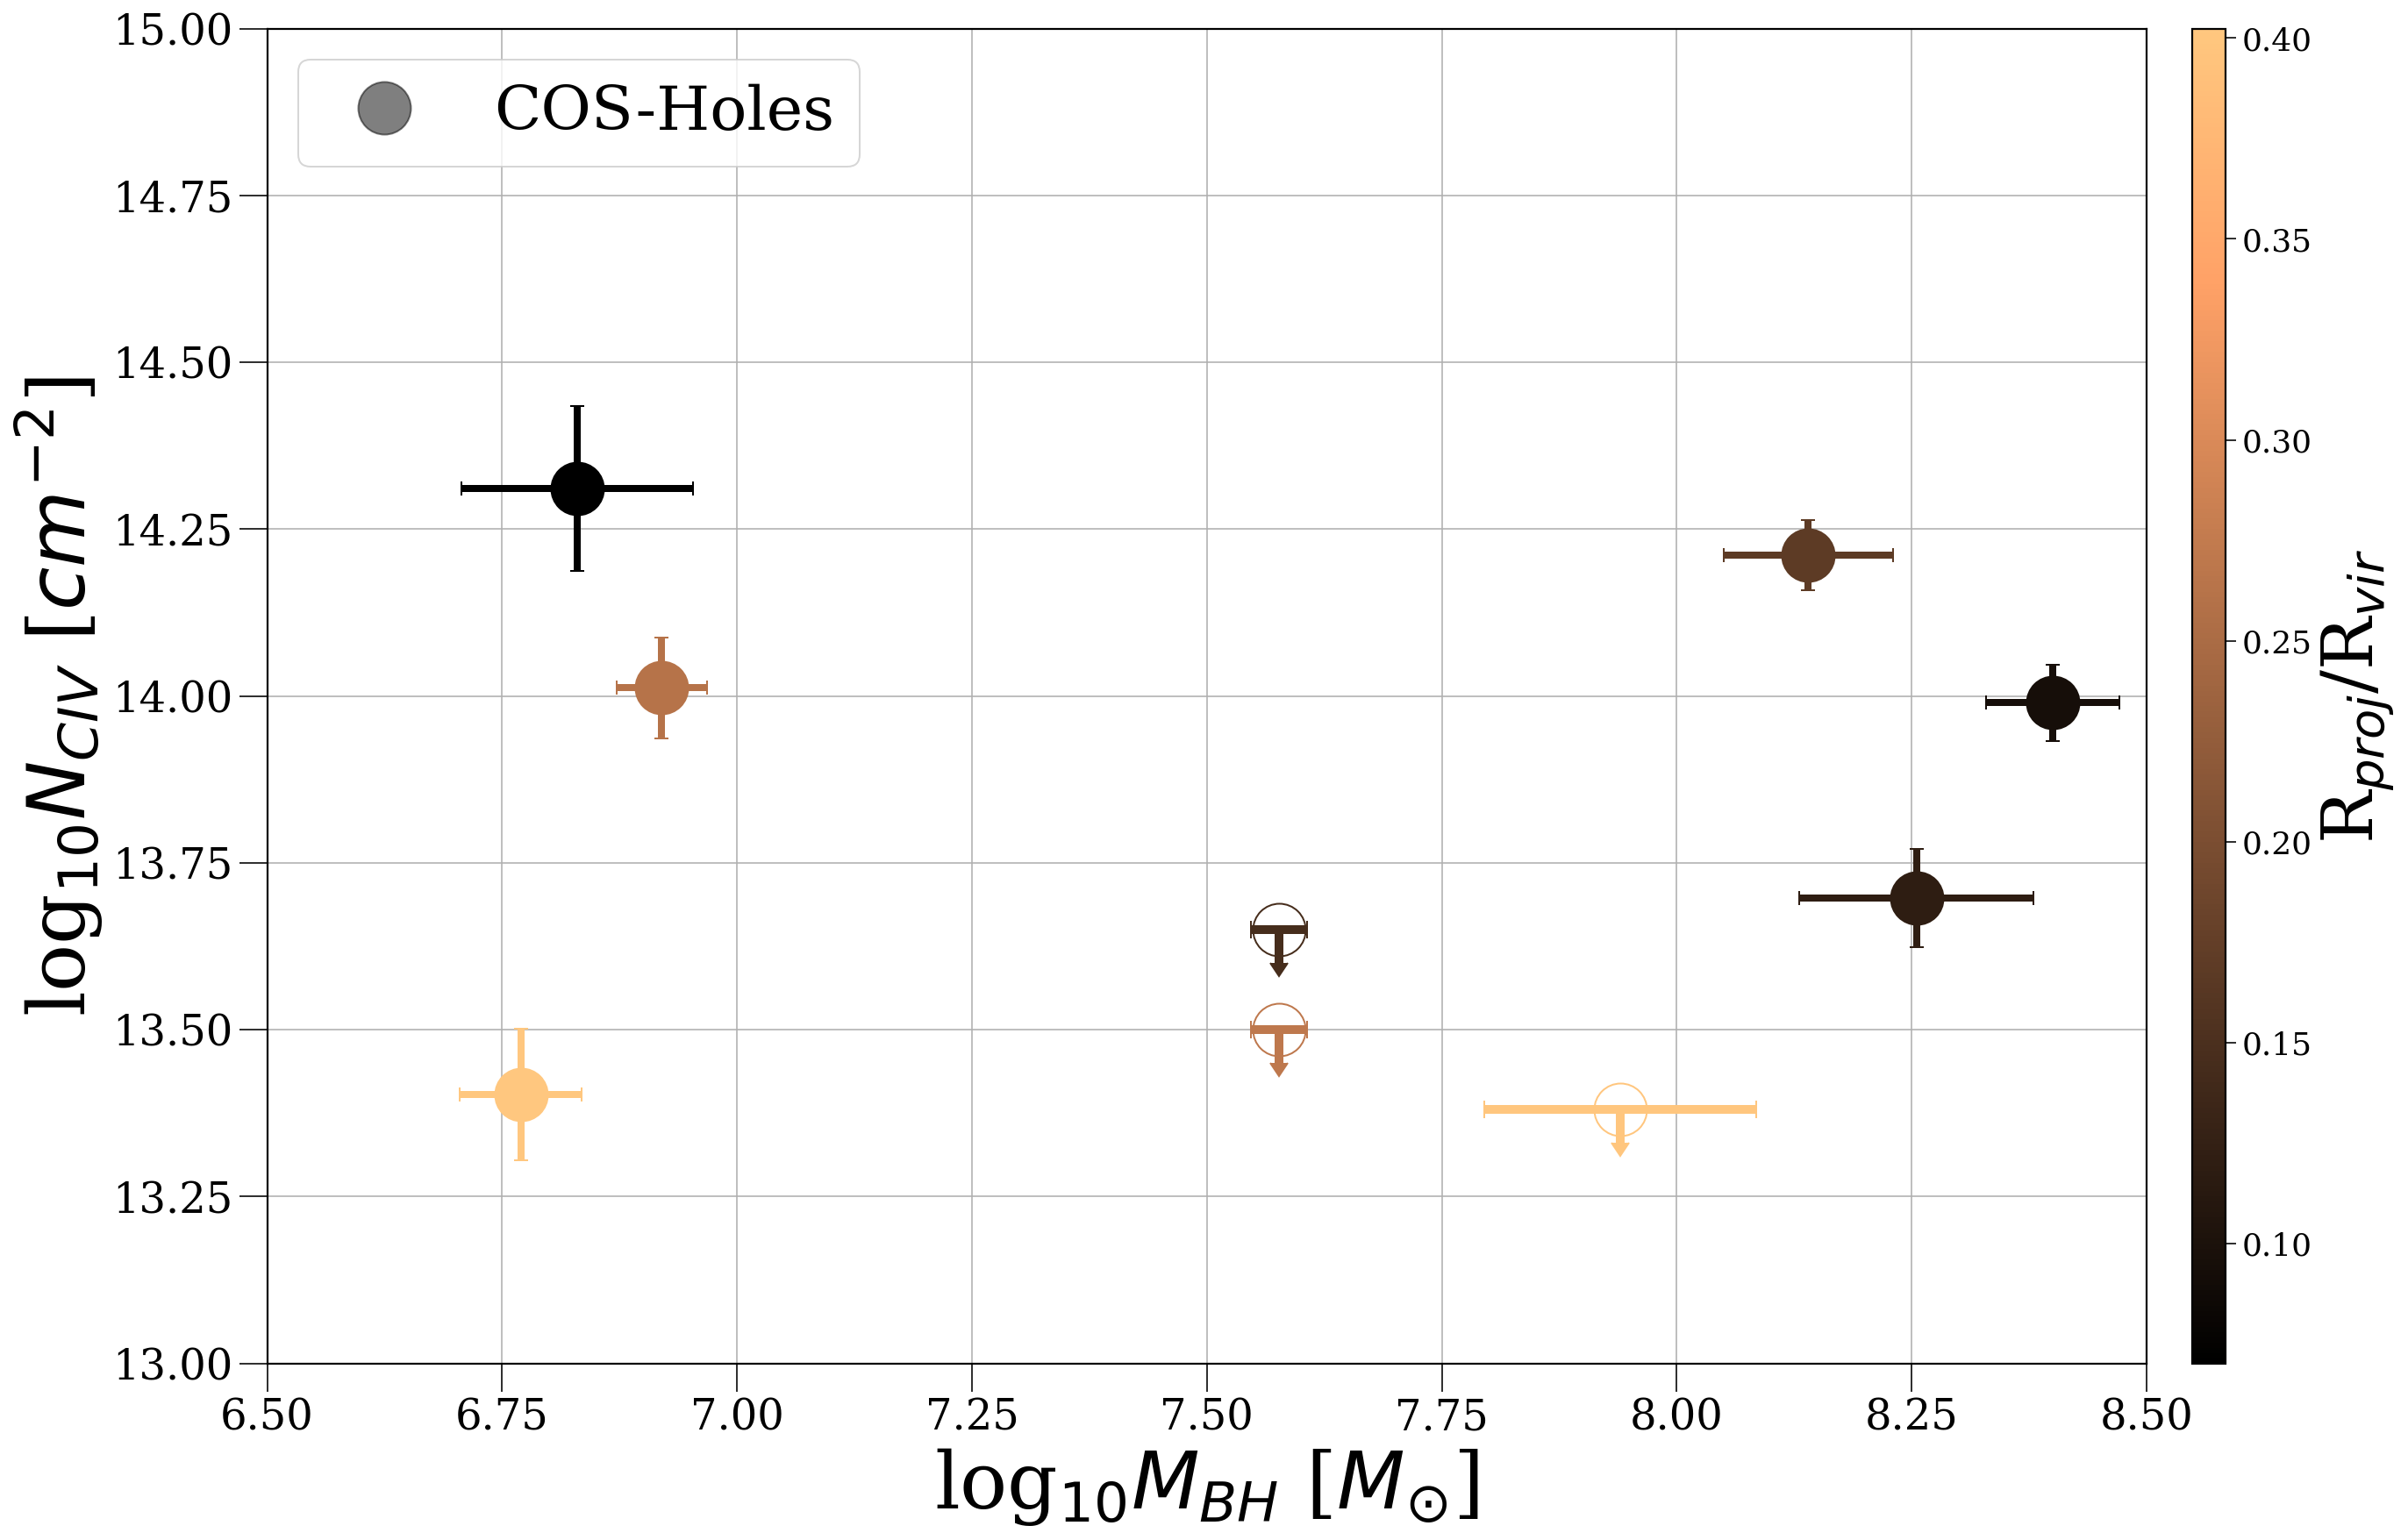

In [129]:
#trying to figure out what Ben wants in his comment here for figure 3 

# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

# Set a grid on your figure so you can define the color bar axis
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
cool = plt.cm.get_cmap('copper')

c = np.asarray(cos_sup['Rproj/Rvir'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
mbh_arr = np.array(cos_sup['MBH'])
N_arr = np.array(cos_sup['N'])
sigN_arr = np.array(cos_sup['sigN'])
sigmbh_arr = np.array(cos_sup['sigMBH'])
uplim_arr = np.array(cos_sup['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o']
marker_size = [70, 30, 30, 30, 50, 50, 50, 70, 70]

#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
#plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Literature', alpha=0.5)
#plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
#plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
#plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)  

    
for i in range(len(mbh_arr)):
    if uplim_arr[i] < 1:  
        plot.errorbar(mbh_arr[i], N_arr[i], 
                yerr=sigN_arr[i], xerr = sigmbh_arr[i],  
                capsize = 5, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=5, mfc='none', uplims=True)
    else: 
        plot.errorbar(mbh_arr[i], N_arr[i], 
                yerr=sigN_arr[i], xerr = sigmbh_arr[i],
                capsize = 4, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=4)
    
# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'R$_{proj}$/R$_{vir}$', size=40)

# Your other stylings from above:
plot.legend(loc=2, fontsize=35) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"log$_{10}M_{BH}$ [$M_{\odot}$]", fontsize=45)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
plot.set_ylim([13, 15])
plot.set_xlim([6.5, 8.5])
plot.grid(True)
#plt.tight_layout()
plt.show()

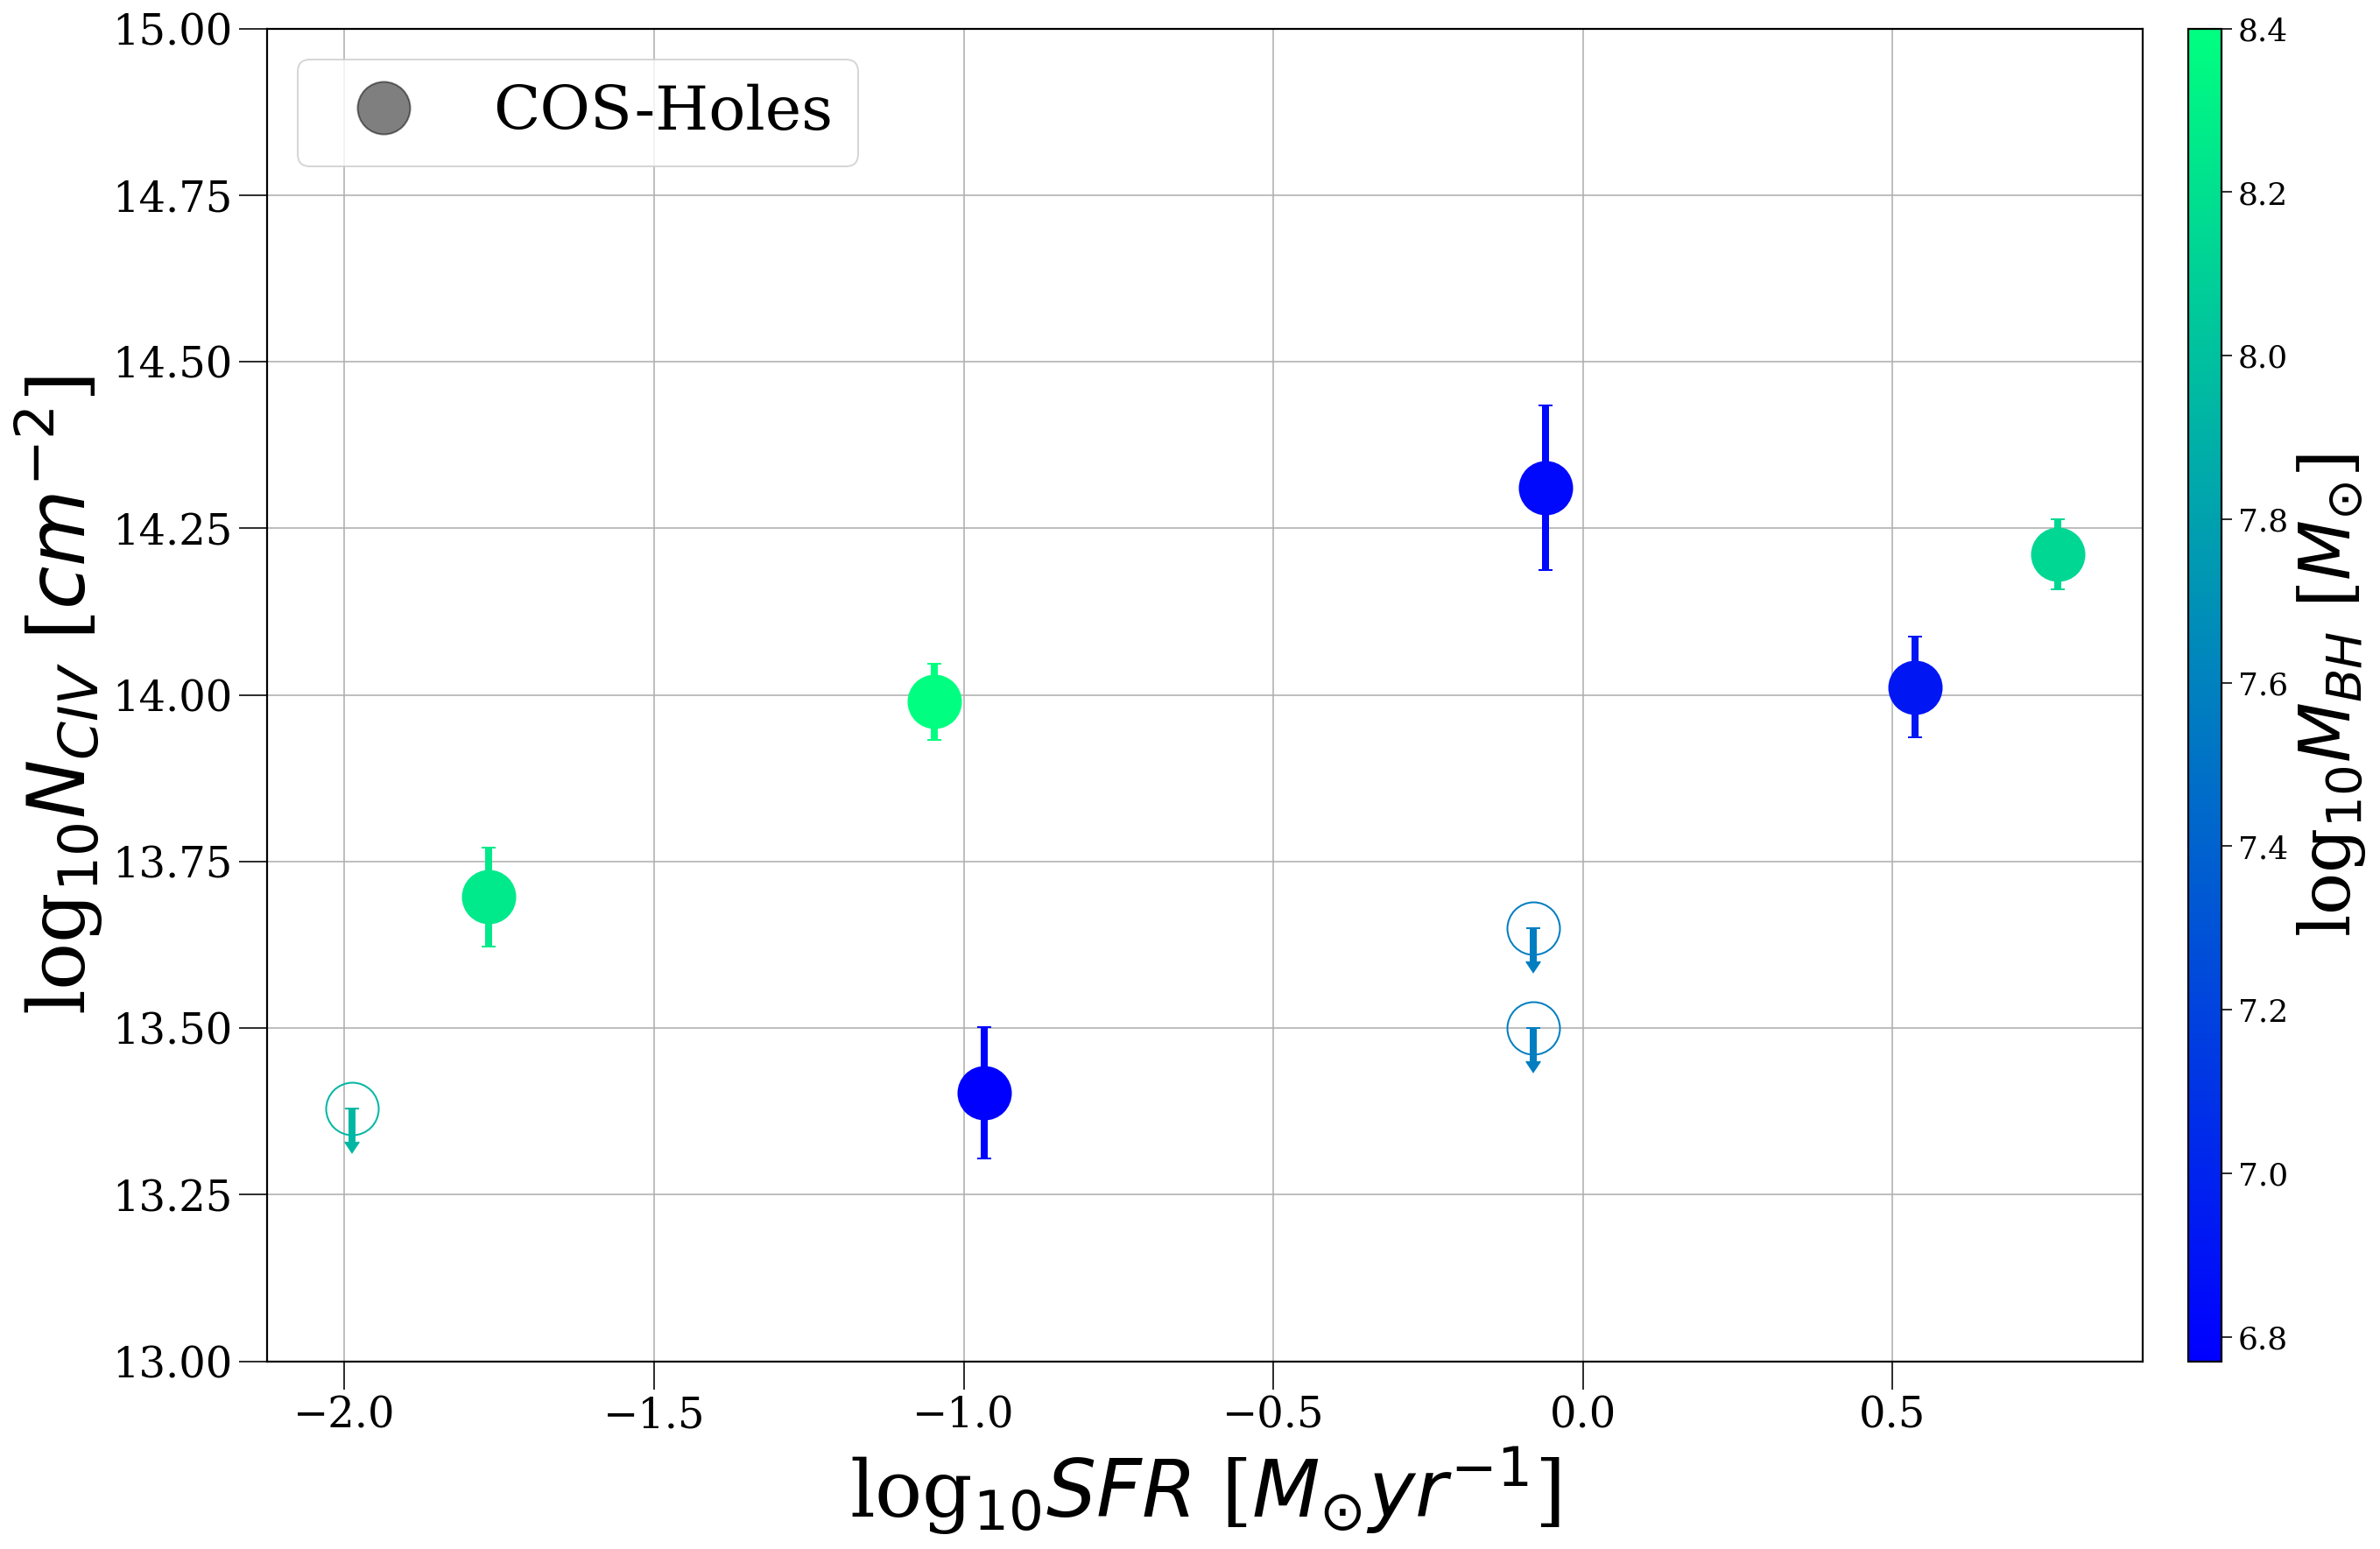

In [131]:
#trying to figure out what Ben wants in his comment here for figure 3 

# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

# Set a grid on your figure so you can define the color bar axis
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
cool = plt.cm.get_cmap('winter')

c = np.asarray(cos_wsfr['MBH'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
sfr_arr = np.array(cos_wsfr['SFR'])
N_arr = np.array(cos_wsfr['N'])
sigN_arr = np.array(cos_wsfr['sigN'])
uplim_arr = np.array(cos_wsfr['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o']

#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
#plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Literature', alpha=0.5)
#plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
#plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
#plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)  

    
for i in range(len(sfr_arr)):
    if uplim_arr[i] < 1:  
        plot.errorbar(sfr_arr[i], N_arr[i], 
                yerr=sigN_arr[i], 
                capsize = 4, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=4, mfc='none', uplims=True)
    else: 
        plot.errorbar(sfr_arr[i], N_arr[i], 
                yerr=sigN_arr[i],
                capsize = 4, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=4)
    
# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r"log$_{10}M_{BH}$ [$M_{\odot}$]", size=40)

# Your other stylings from above:
plot.legend(loc=2, fontsize=35) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"log$_{10}SFR$ [$M_{\odot} yr^{-1}$]", fontsize=45)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
plot.set_ylim([13, 15])
#plot.set_xlim([6.5, 8.5])
plot.grid(True)
#plt.tight_layout()
plt.show()

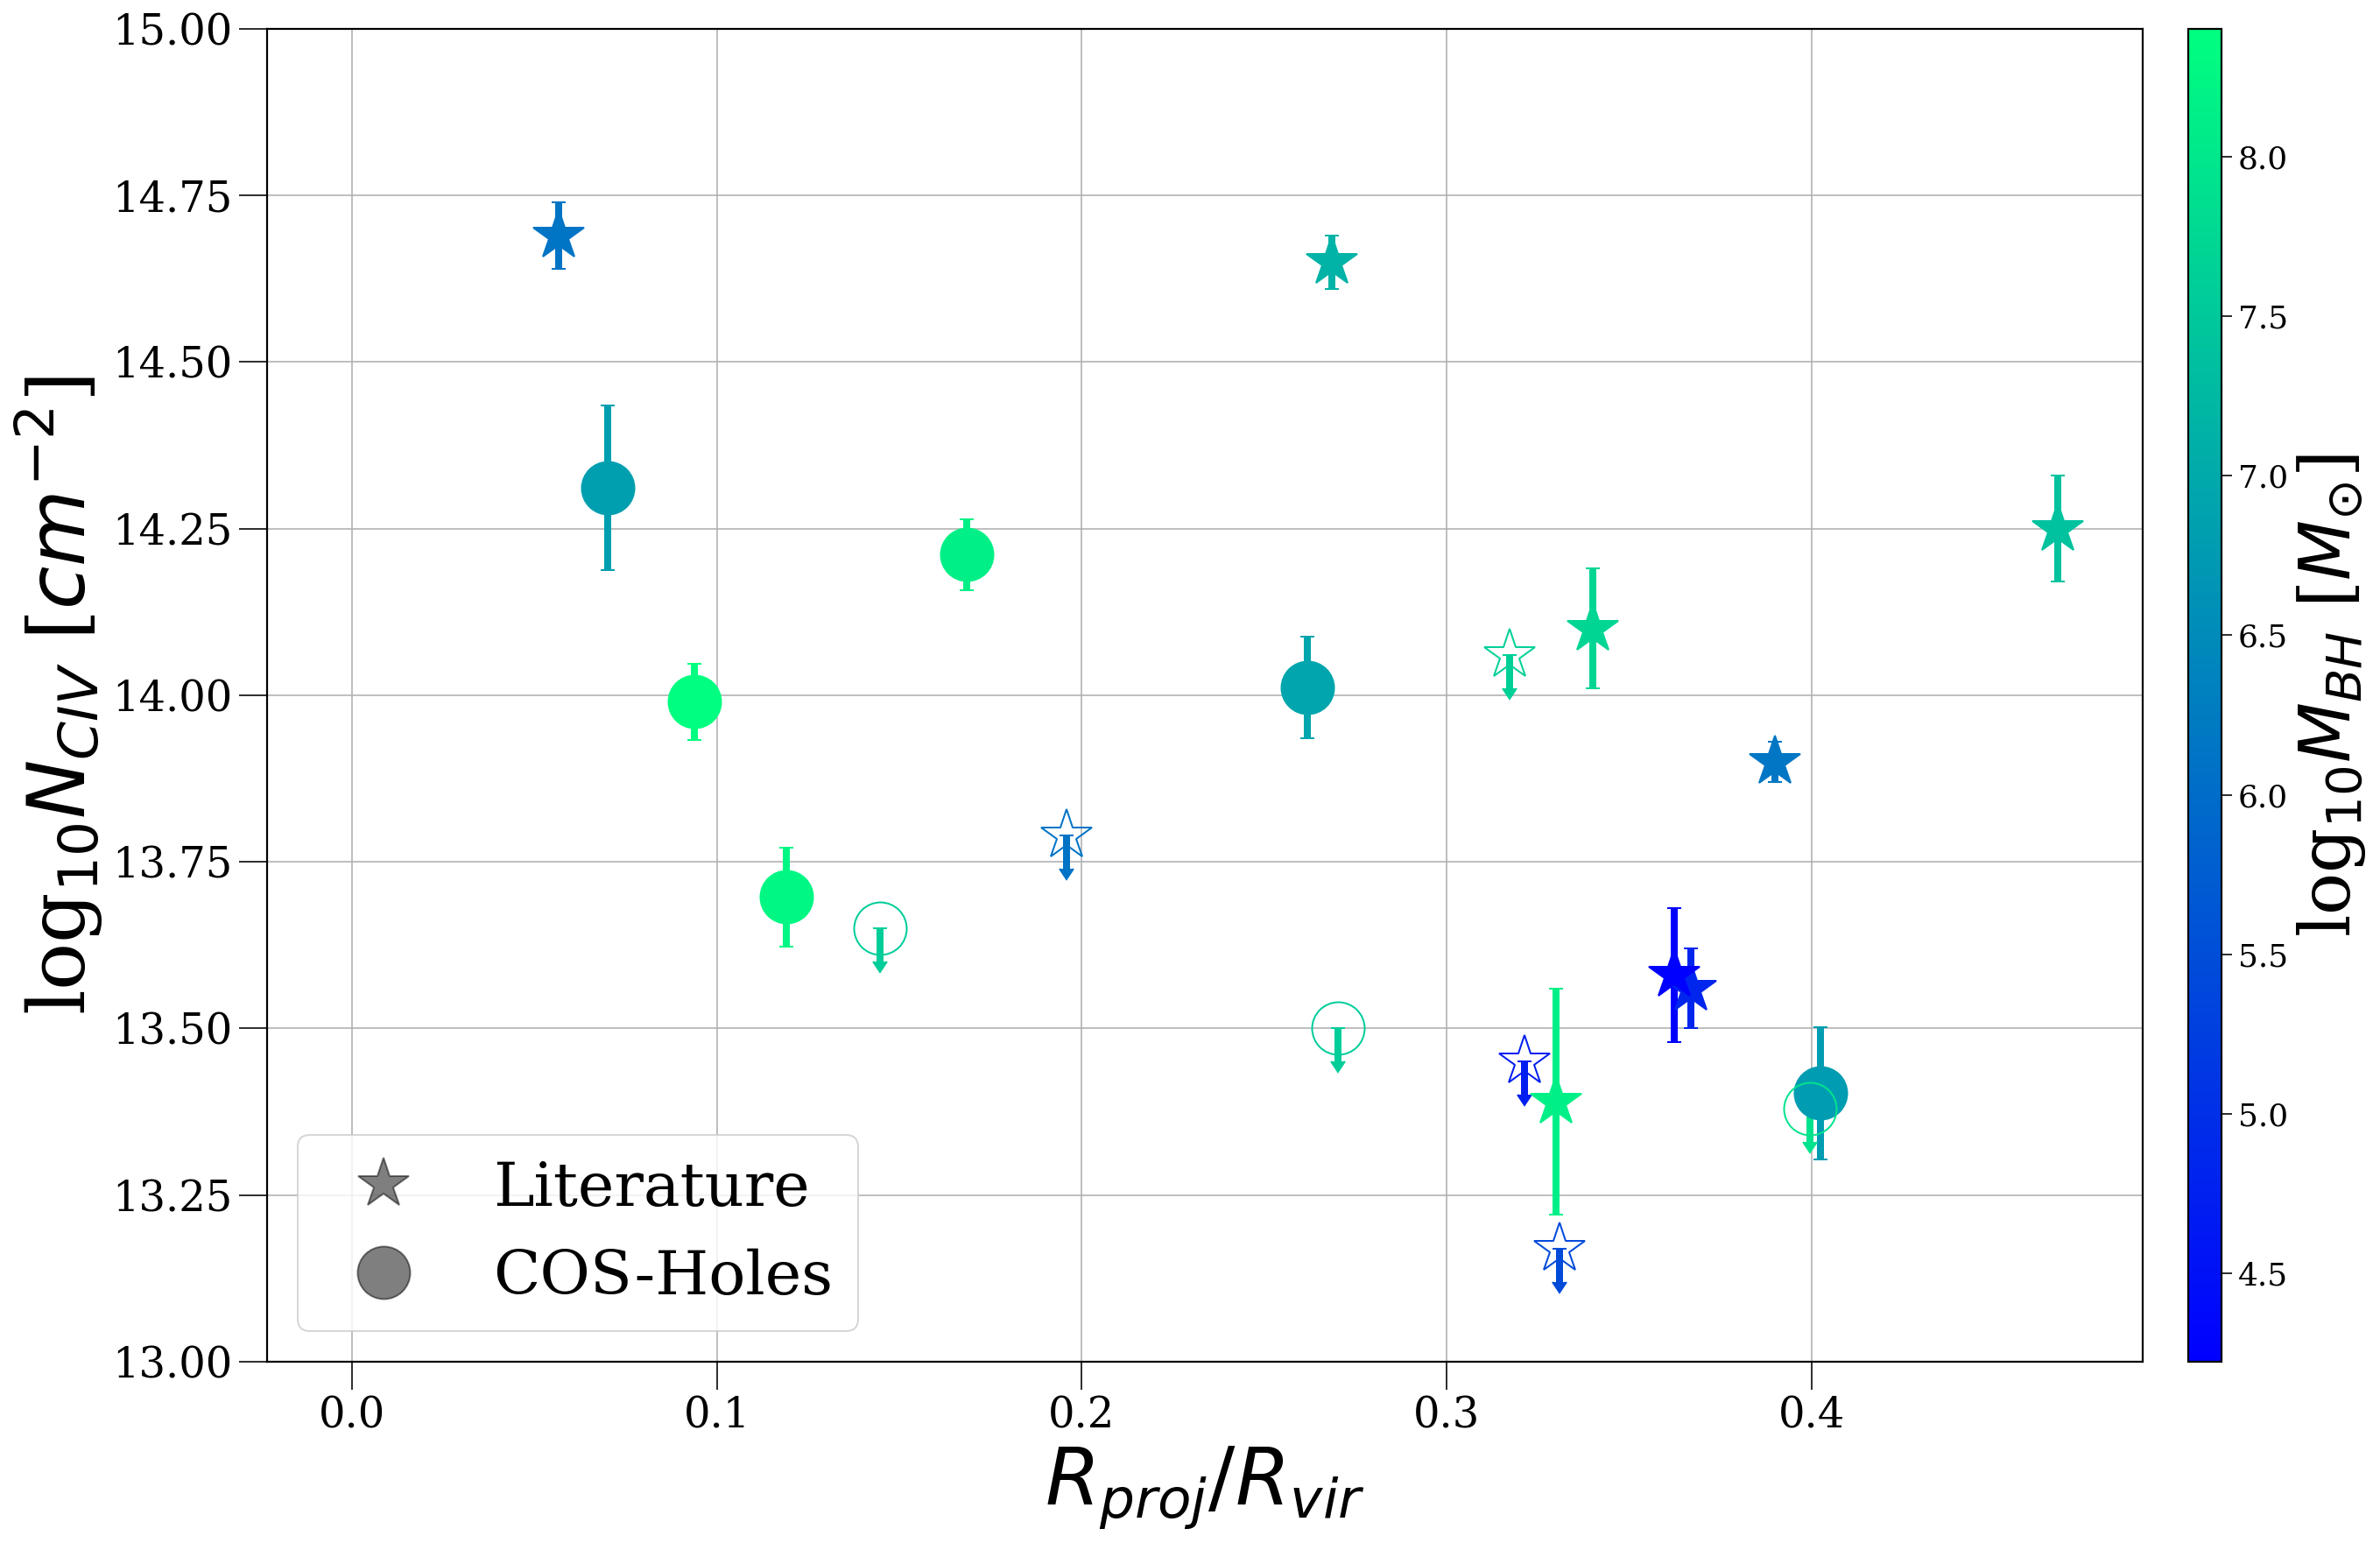

In [132]:
# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

UL = np.array(coslit['uplim'])
has_UL = UL < 1

# Set a grid on your figure so you can define the color bar axis
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
cool = plt.cm.get_cmap('winter')

#c = np.asarray(coslit['MBH'])
c = np.asarray(coslit['MBH'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
r_arr = np.array(coslit['Rproj/Rvir'])
N_arr = np.array(coslit['N'])
sigN_arr = np.array(coslit['sigN'])
#sigmbh_arr = np.array(coslit['sigMBH'])
uplim_arr = np.array(coslit['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o', 
                '*', '*', '*', '*', 
               '*', '*', '*', '*', '*', 
               '*', '*',
               '*']


#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Literature', alpha=0.5)
#plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
#plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
#plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)


for i in range(len(r_arr)):
    if uplim_arr[i] < 1:  
        plot.errorbar(r_arr[i], N_arr[i], 
                yerr=sigN_arr[i],  
                capsize = 4, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=4, mfc='none', uplims=True)
    else: 
        plot.errorbar(r_arr[i], N_arr[i], 
                yerr=sigN_arr[i], 
                capsize = 4, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=4)
    
# I changed some of your sizes cause they looked too big with my code ig

# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'log$_{10}M_{BH}$ [$M_{\odot}$]', size=40)

# Your other stylings from above:
plot.legend(loc=3, fontsize=35) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
plot.set_ylim([13, 15])
#plot.set_xlim([4, 9])
plot.grid(True)
#plt.tight_layout()
plt.show()

In [ ]:
c_mbh_na = np.array([6.77      , 8.255     , 6.83      , 8.4       , 6.92      ,
       8.14      , 7.577     , 7.577     , 7.94      , 6.10533953,
       7.62918901, 7.16002989, 7.39812803, 5.4467845 , 5.446,
       5.446, 5.446, 6.12716341, 7.7057337 , 6.15592829, 8.15])
c_mbh_na

In [ ]:
c_mbh = np.array([6.77      , 8.255     , 6.83      , 8.4       , 6.92      ,
       8.14      , 7.577     , 7.577     , 7.94      , 6.10533953,
       7.62918901, 7.16002989, 7.39812803, 5.4467845 , 4.5,
       4.8, 5.446, 6.12716341, 7.7057337 , 6.15592829, 8.15])
c_mbh

## Simulation Panel Figure 

In [72]:
########################################################

# R25: New Data from Nicole (June 5th 2023)

r25_rr = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_RoverRvir_new.txt', 
                       sep=" ", header=None, names =['Rproj/Rvir'])
r25_r = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/COSholes_Rkpc.txt', 
                       sep=" ", header=None, names =['Rproj'])

#High MBH Things 
hmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
hmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_16percentile_new.txt.txt', 
                       sep=" ", header=None, names =['16per'])
hmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_highMbh_logN_CIV_84percentile_new.txt.txt', 
                       sep=" ", header=None, names =['84per'])

#Low MBH Things 
lmbh_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])
lmbh_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])
lmbh_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_lowMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

#Galaxy Histogram info 
r25_mhalo = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mhalo.txt', 
                       sep=" ", header=None, names =['Mhalo'])

r25_mbh = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Msmbh.txt', 
                       sep=" ", header=None, names =['Mbh'])

r25_mstar = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_Mstar.txt', 
                       sep=" ", header=None, names =['Mhalo'])

#All the MBH together
all_r25_civ = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_new.txt', 
                       sep=" ", header=None, names =['logNciv'])

all_r25_16 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_16percentile_new.txt', 
                       sep=" ", header=None, names =['16per'])


all_r25_84 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/R25/newChaNGa_bugfix/COSholes_ChaNGa_allMbh_logN_CIV_84percentile_new.txt', 
                       sep=" ", header=None, names =['84per'])

########################################################

# EAGLE 

df_r_new_low = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH46_96_2bins.MS100_110.4.6_7.1.csv")
df_r_new_high = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH46_96_2bins.MS100_110.7.1_9.6.csv")
df_r_new_all = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_EAGLE.halo.list.CIV_median.MBH46_96_1bins.MS100_110.4.6_9.6.csv")

#EAGLE

df_rr_new_low = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_EAGLE.halo.list.CIV_median.MBH46_96_2bins.MS100_110.4.6_7.1.csv")
df_rr_new_high = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_EAGLE.halo.list.CIV_median.MBH46_96_2bins.MS100_110.7.1_9.6.csv")
df_rr_new_all = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_EAGLE.halo.list.CIV_median.MBH46_96_1bins.MS100_110.4.6_9.6.csv")

########################################################

# TNG 

df_rr_new_lowtng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_TNG.halo.list.CIV_median.MBH55_107_2bins.MS100_110.5.52_8.120000000000001.csv")
df_rr_new_hightng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_TNG.halo.list.CIV_median.MBH55_107_2bins.MS100_110.8.120000000000001_10.72.csv")
df_rr_new_alltng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_TNG.halo.list.CIV_median.MBH55_107_1bins.MS100_110.5.52_10.72.csv")

df_r_new_lowtng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_TNG.halo.list.CIV_median.MBH55_107_2bins.MS100_110.5.52_8.120000000000001.csv")
df_r_new_hightng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_TNG.halo.list.CIV_median.MBH55_107_2bins.MS100_110.8.120000000000001_10.72.csv")
df_r_new_alltng = pd.read_csv("/Users/samgarza/Documents/COS-Holes/EAGLE_TNG_updated_data_Jun11/sam_csv/profile_coll_kpc_TNG.halo.list.CIV_median.MBH55_107_1bins.MS100_110.5.52_10.72.csv")


In [73]:
#Creating masks for literature individually bc the whole df wants to be a dick right now 

low_mask_new, high_mask_new = (cosholes_df["MBH"] <= 7), (cosholes_df["MBH"] > 7)

#Creating masks for literature 

low_mask_lit_new, high_mask_lit_new = (coslit["MBH"] <= 7), (coslit["MBH"] > 7)

#Creating masks for literature individually bc the whole df wants to be a dick right now 

low_mask_borth_new, high_mask_borth_new = (borthakur_new["MBH"] <= 7), (borthakur_new["MBH"] > 7)
low_mask_bord_new, high_mask_bord_new = (bordoloi_new["MBH"] <= 7), (bordoloi_new["MBH"] > 7)
low_mask_halos_new, high_mask_halos_new = (COSHALOS["MBH"] <= 7), (COSHALOS["MBH"] > 7)

<>:15: DeprecationWarning: invalid escape sequence \o
<>:19: DeprecationWarning: invalid escape sequence \o
<>:90: DeprecationWarning: invalid escape sequence \o
<>:93: DeprecationWarning: invalid escape sequence \o
<>:165: DeprecationWarning: invalid escape sequence \o
<>:168: DeprecationWarning: invalid escape sequence \o
<>:246: DeprecationWarning: invalid escape sequence \l
<>:320: DeprecationWarning: invalid escape sequence \o
<>:392: DeprecationWarning: invalid escape sequence \o
<>:15: DeprecationWarning: invalid escape sequence \o
<>:19: DeprecationWarning: invalid escape sequence \o
<>:90: DeprecationWarning: invalid escape sequence \o
<>:93: DeprecationWarning: invalid escape sequence \o
<>:165: DeprecationWarning: invalid escape sequence \o
<>:168: DeprecationWarning: invalid escape sequence \o
<>:246: DeprecationWarning: invalid escape sequence \l
<>:320: DeprecationWarning: invalid escape sequence \o
<>:392: DeprecationWarning: invalid escape sequence \o
<>:15: Deprecation

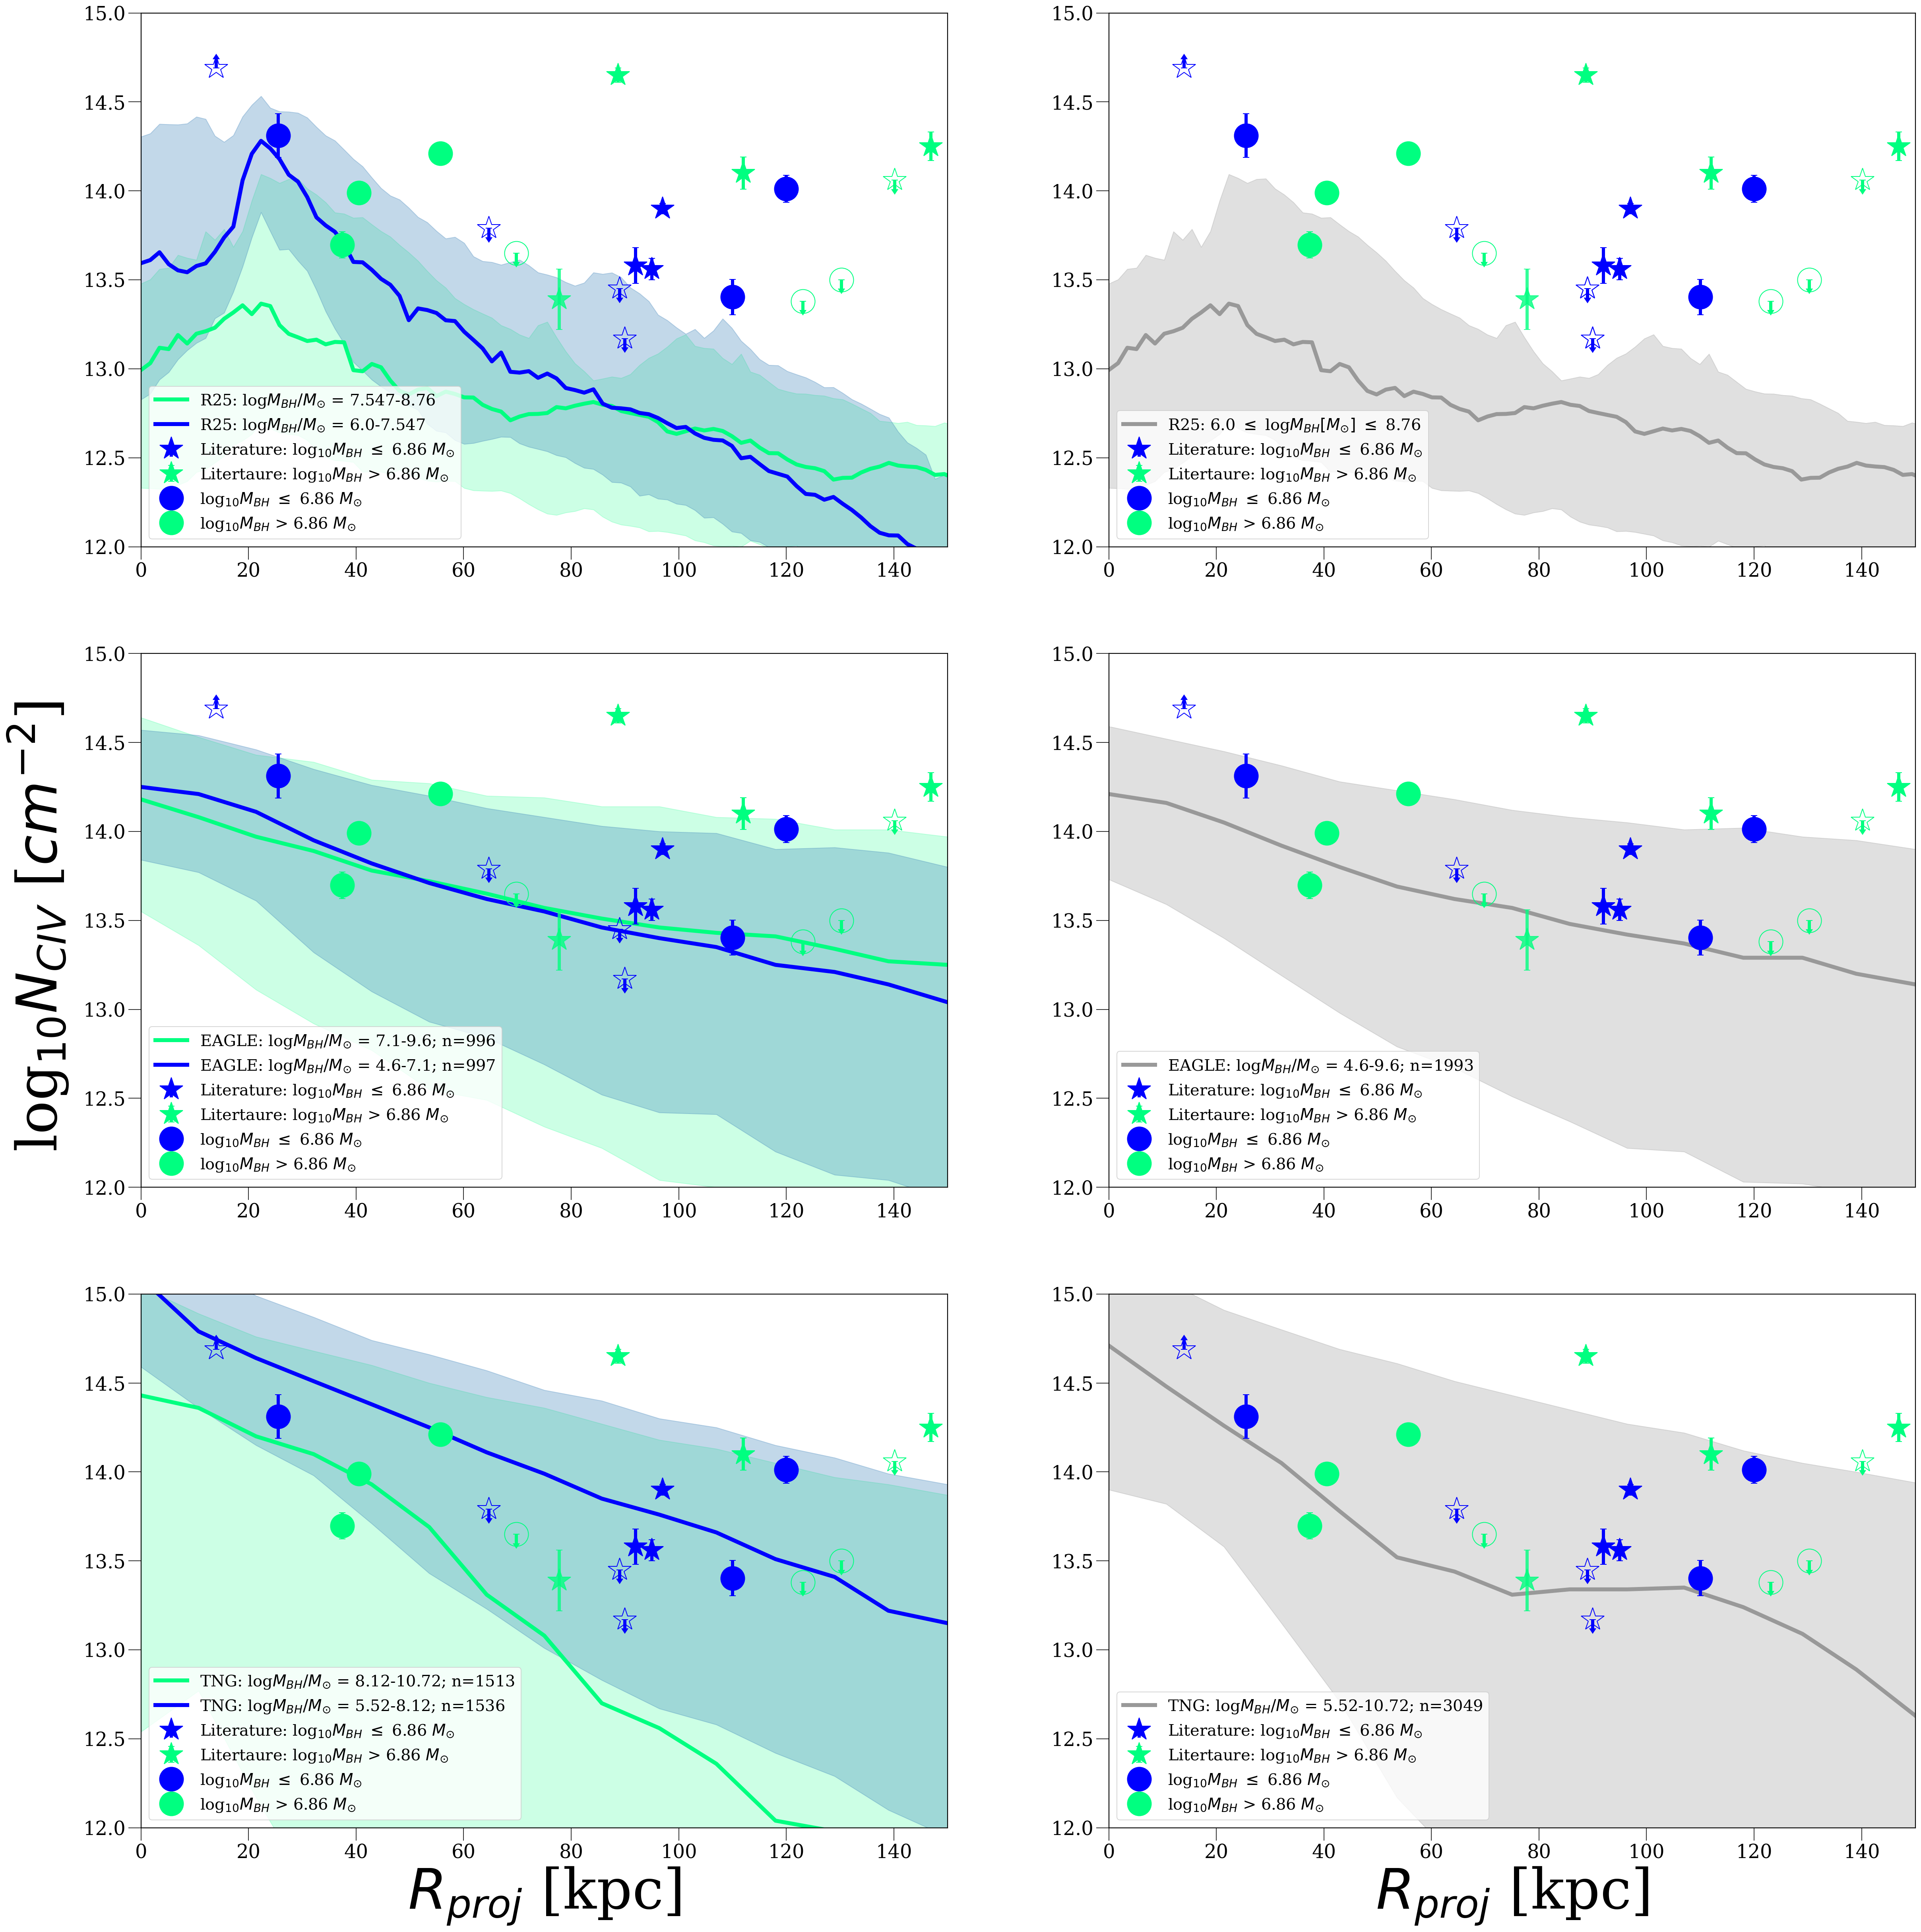

In [81]:
#Plotting NCIV vs R/Rvir     
fig, ax = plt.subplots(3,2, figsize=(40,42))
    #This one works wellish: 50,42

#######################################################

#PLOT 1

#######################################################

#R25

ax[0,0].fill_between(r25_r['Rproj'], hmbh_16['16per'], hmbh_84['84per'], alpha = 0.2, color = '#00ff80')
ax[0,0].plot(r25_r['Rproj'], hmbh_civ['logNciv'], c = '#00ff80', linewidth = 5, ls = '-',
         label = 'R25: log$M_{BH}/M_{\odot}$ = 7.547-8.76')

ax[0,0].fill_between(r25_r['Rproj'], lmbh_16['16per'], lmbh_84['84per'], alpha = 0.3, color = CB_color_cycle[0])
ax[0,0].plot(r25_r['Rproj'], lmbh_civ['logNciv'], c = '#0000ff', linewidth = 5, ls = '-',
         label = 'R25: log$M_{BH}/M_{\odot}$ = 6.0-7.547')


##################################
##### M31 Detections (Sums) 
ax[0,0].errorbar (AMIGA['Rproj'], AMIGA['N'], yerr=AMIGA['sigN'],capsize = 4, c = '#00ff80', 
              alpha=0.8, marker="*", markersize=30, ls='none', elinewidth=4)

########################################################


########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth_new, high_mask_borth_new], ['#0000ff', '#00ff80'], 
                               [r"Literature: log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"Litertaure: log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[0,0].errorbar(borth_det['Rproj'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[0,0].errorbar(borth_uplim['Rproj'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
########## Bordoloi ##########
    
for mask, colour, in zip([low_mask_bord_new, high_mask_bord_new], ['#0000ff', '#00ff80']):
    
    ax[0,0].errorbar(bord_det['Rproj'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)
    
    ax[0,0].errorbar(bord_uplim['Rproj'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
    ax[0,0].errorbar(bord_lolim['Rproj'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=4)
    
########## COS-HAlOS ##########

for mask, colour in zip([low_mask_halos_new, high_mask_halos_new], ['#0000ff', '#00ff80']):
    
    ax[0,0].errorbar(COSHALOS['Rproj'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], 
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)


########################################################
    
for mask, colour, label in zip([low_mask_new, high_mask_new], ['#0000ff', '#00ff80'], 
                               [r"log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[0,0].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[0,0].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    

ax[0,0].legend(loc=3, fontsize=20)
ax[0,0].set_ylim(12, 15)
ax[0,0].set_xlim(0, 150)


########################################################
#PLOT 2
#######################################################

#EAGLE

ax[1,0].fill_between(df_r_new_high['R(kpc)'], df_r_new_high['16percentile'], df_r_new_high['84percentile'], alpha = 0.2, color = '#00ff80')
ax[1,0].plot(df_r_new_high['R(kpc)'], df_r_new_high['median'], color = '#00ff80', lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 7.1-9.6; n=996')

ax[1,0].fill_between(df_r_new_low['R(kpc)'], df_r_new_low['16percentile'], df_r_new_low['84percentile'], alpha = 0.3, color = CB_color_cycle[0])
ax[1,0].plot(df_r_new_low['R(kpc)'], df_r_new_low['median'], color = '#0000ff', lw = 5, label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 4.6-7.1; n=997')


#################################
#### LITERATURE SAMPLE 
    
##################################
##### M31 Detections (Sums) 
ax[1,0].errorbar (AMIGA['Rproj'], AMIGA['N'], yerr=AMIGA['sigN'],capsize = 4, c = '#00ff80', 
              alpha=0.8, marker="*", markersize=30, ls='none', elinewidth=4)

########################################################


########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth_new, high_mask_borth_new], ['#0000ff', '#00ff80'], 
                               [r"Literature: log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"Litertaure: log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[1,0].errorbar(borth_det['Rproj'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[1,0].errorbar(borth_uplim['Rproj'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
########## Bordoloi ##########
    
for mask, colour, in zip([low_mask_bord_new, high_mask_bord_new], ['#0000ff', '#00ff80']):
    
    ax[1,0].errorbar(bord_det['Rproj'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)
    
    ax[1,0].errorbar(bord_uplim['Rproj'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
    ax[1,0].errorbar(bord_lolim['Rproj'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=4)
    
########## COS-HAlOS ##########

for mask, colour in zip([low_mask_halos_new, high_mask_halos_new], ['#0000ff', '#00ff80']):
    
    ax[1,0].errorbar(COSHALOS['Rproj'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], 
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)


########################################################
    
for mask, colour, label in zip([low_mask_new, high_mask_new], ['#0000ff', '#00ff80'], 
                               [r"log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[1,0].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[1,0].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)

ax[1,0].legend(loc=3, fontsize=20)
ax[1,0].set_ylim(12, 15)
ax[1,0].set_xlim(0, 150)
    
########################################################
#PLOT 3
########################################################

#TNG
    
ax[2,0].fill_between(df_r_new_hightng['R(kpc)'], df_r_new_hightng['16percentile'], df_r_new_hightng['84percentile'], alpha = 0.2, color = '#00ff80')
ax[2,0].plot(df_r_new_hightng['R(kpc)'], df_r_new_hightng['median'], color = '#00ff80', lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 8.12-10.72; n=1513')

ax[2,0].fill_between(df_r_new_lowtng['R(kpc)'], df_r_new_lowtng['16percentile'], df_r_new_lowtng['84percentile'], alpha = 0.3, color = CB_color_cycle[0])
ax[2,0].plot(df_r_new_lowtng['R(kpc)'], df_r_new_lowtng['median'], color = '#0000ff', lw = 5, label = 'TNG: log$M_{BH}/M_{\odot}$ = 5.52-8.12; n=1536')
    

##############################
#### LITERATURE SAMPLE 

##################################
##### M31 Detections (Sums) 
ax[2,0].errorbar (AMIGA['Rproj'], AMIGA['N'], yerr=AMIGA['sigN'],capsize = 4, c = '#00ff80', 
              alpha=0.8, marker="*", markersize=30, ls='none', elinewidth=4)

########################################################


########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth_new, high_mask_borth_new], ['#0000ff', '#00ff80'], 
                               [r"Literature: log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"Litertaure: log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[2,0].errorbar(borth_det['Rproj'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[2,0].errorbar(borth_uplim['Rproj'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
########## Bordoloi ##########
    
for mask, colour, in zip([low_mask_bord_new, high_mask_bord_new], ['#0000ff', '#00ff80']):
    
    ax[2,0].errorbar(bord_det['Rproj'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)
    
    ax[2,0].errorbar(bord_uplim['Rproj'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
    ax[2,0].errorbar(bord_lolim['Rproj'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=4)
    
########## COS-HAlOS ##########

for mask, colour in zip([low_mask_halos_new, high_mask_halos_new], ['#0000ff', '#00ff80']):
    
    ax[2,0].errorbar(COSHALOS['Rproj'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], 
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)


########################################################
    
for mask, colour, label in zip([low_mask_new, high_mask_new], ['#0000ff', '#00ff80'], 
                               [r"log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[2,0].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[2,0].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    

ax[2,0].legend(loc=3, fontsize=20)
ax[2,0].set_xlabel(r"$R_{proj}$ [kpc]", fontsize=70)
ax[2,0].set_ylim(12, 15)
ax[2,0].set_xlim(0, 150)


#######################################################

#PLOT 4

#######################################################

#R25

ax[0,1].fill_between(r25_r['Rproj'], all_r25_16['16per'], all_r25_84['84per'], alpha = 0.3, color = CB_color_cycle[6])
ax[0,1].plot(r25_r['Rproj'], all_r25_civ['logNciv'], 
         c = CB_color_cycle[6], linewidth = 5, ls = '-', label = 'R25: 6.0 $\leq$ log$M_{BH} [M_{\odot}]$ $\leq$ 8.76')


##################################
#### LITERATURE SAMPLE 
##################################
##### M31 Detections (Sums) 
ax[0,1].errorbar (AMIGA['Rproj'], AMIGA['N'], yerr=AMIGA['sigN'],capsize = 4, c = '#00ff80', 
              alpha=0.8, marker="*", markersize=30, ls='none', elinewidth=4)

########################################################


########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth_new, high_mask_borth_new], ['#0000ff', '#00ff80'], 
                               [r"Literature: log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"Litertaure: log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[0,1].errorbar(borth_det['Rproj'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[0,1].errorbar(borth_uplim['Rproj'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
########## Bordoloi ##########
    
for mask, colour, in zip([low_mask_bord_new, high_mask_bord_new], ['#0000ff', '#00ff80']):
    
    ax[0,1].errorbar(bord_det['Rproj'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)
    
    ax[0,1].errorbar(bord_uplim['Rproj'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
    ax[0,1].errorbar(bord_lolim['Rproj'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=4)
    
########## COS-HAlOS ##########

for mask, colour in zip([low_mask_halos_new, high_mask_halos_new], ['#0000ff', '#00ff80']):
    
    ax[0,1].errorbar(COSHALOS['Rproj'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], 
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)


########################################################
    
for mask, colour, label in zip([low_mask_new, high_mask_new], ['#0000ff', '#00ff80'], 
                               [r"log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[0,1].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[0,1].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    

ax[0,1].legend(loc=3, fontsize=20)
ax[0,1].set_ylim(12, 15)
ax[0,1].set_xlim(0, 150)


########################################################
#PLOT 5
#######################################################

#EAGLE

ax[1,1].fill_between(df_r_new_all['R(kpc)'], df_r_new_all['16percentile'], df_r_new_all['84percentile'], alpha = 0.3, color = CB_color_cycle[6])
ax[1,1].plot(df_r_new_all['R(kpc)'], df_r_new_all['median'], c = CB_color_cycle[6], linewidth = 5, ls = '-',
         label = 'EAGLE: log$M_{BH}/M_{\odot}$ = 4.6-9.6; n=1993')

#################################
#### LITERATURE SAMPLE 
##################################
##### M31 Detections (Sums) 
ax[1,1].errorbar (AMIGA['Rproj'], AMIGA['N'], yerr=AMIGA['sigN'],capsize = 4, c = '#00ff80', 
              alpha=0.8, marker="*", markersize=30, ls='none', elinewidth=4)

########################################################


########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth_new, high_mask_borth_new], ['#0000ff', '#00ff80'], 
                               [r"Literature: log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"Litertaure: log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[1,1].errorbar(borth_det['Rproj'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[1,1].errorbar(borth_uplim['Rproj'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
########## Bordoloi ##########
    
for mask, colour, in zip([low_mask_bord_new, high_mask_bord_new], ['#0000ff', '#00ff80']):
    
    ax[1,1].errorbar(bord_det['Rproj'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)
    
    ax[0,1].errorbar(bord_uplim['Rproj'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
    ax[1,1].errorbar(bord_lolim['Rproj'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=4)
    
########## COS-HAlOS ##########

for mask, colour in zip([low_mask_halos_new, high_mask_halos_new], ['#0000ff', '#00ff80']):
    
    ax[1,1].errorbar(COSHALOS['Rproj'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], 
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)


########################################################
    
for mask, colour, label in zip([low_mask_new, high_mask_new], ['#0000ff', '#00ff80'], 
                               [r"log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[1,1].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[1,1].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    

ax[1,1].legend(loc=3, fontsize=20)
ax[1,1].set_ylim(12, 15)
ax[1,1].set_xlim(0, 150)
    
########################################################
#PLOT 6
########################################################

#TNG
    
ax[2,1].fill_between(df_r_new_alltng['R(kpc)'], df_r_new_alltng['16percentile'], df_r_new_alltng['84percentile'], alpha = 0.3, color = CB_color_cycle[6])
ax[2,1].plot(df_r_new_alltng['R(kpc)'], df_rr_new_alltng['median'], c = CB_color_cycle[6], linewidth = 5, ls = '-',
         label = 'TNG: log$M_{BH}/M_{\odot}$ = 5.52-10.72; n=3049')

##############################
#### LITERATURE SAMPLE 
##################################
##### M31 Detections (Sums) 
ax[2,1].errorbar (AMIGA['Rproj'], AMIGA['N'], yerr=AMIGA['sigN'],capsize = 4, c = '#00ff80', 
              alpha=0.8, marker="*", markersize=30, ls='none', elinewidth=4)

########################################################


########## Borthakur ##########

for mask, colour, label in zip([low_mask_borth_new, high_mask_borth_new], ['#0000ff', '#00ff80'], 
                               [r"Literature: log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"Litertaure: log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[2,1].errorbar(borth_det['Rproj'][mask], borth_det['N'][mask],yerr=borth_det['sigN'][mask], #xerr=borth_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[2,1].errorbar(borth_uplim['Rproj'][mask], borth_uplim['N'][mask],yerr=borth_uplim['sigN'][mask], #xerr=borth_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
########## Bordoloi ##########
    
for mask, colour, in zip([low_mask_bord_new, high_mask_bord_new], ['#0000ff', '#00ff80']):
    
    ax[2,1].errorbar(bord_det['Rproj'][mask], bord_det['N'][mask],yerr=bord_det['sigN'][mask], #xerr=bord_det['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)
    
    ax[2,1].errorbar(bord_uplim['Rproj'][mask], bord_uplim['N'][mask],yerr=bord_uplim['sigN'][mask], #xerr=bord_uplim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
    ax[2,1].errorbar(bord_lolim['Rproj'][mask], bord_lolim['N'][mask],yerr=bord_lolim['sigN'][mask], #xerr=bord_lolim['MBH_err'][mask],
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', lolims=True, mfc='none', elinewidth=4)
    
########## COS-HAlOS ##########

for mask, colour in zip([low_mask_halos_new, high_mask_halos_new], ['#0000ff', '#00ff80']):
    
    ax[2,1].errorbar(COSHALOS['Rproj'][mask], COSHALOS['N'][mask],yerr=COSHALOS['sigN'][mask], 
                capsize = 4, c = colour, marker="*", markersize=30, ls='none', elinewidth=4)


########################################################
    
for mask, colour, label in zip([low_mask_new, high_mask_new], ['#0000ff', '#00ff80'], 
                               [r"log$_{10}M_{BH}$ $\leq$ 6.86 $M_{\odot}$", 
                                r"log$_{10}M_{BH}$ > 6.86 $M_{\odot}$"]):
    
    ax[2,1].errorbar(sum_ch["Rproj"][mask], sum_ch['N'][mask], 
                yerr=sum_ch['sigN'][mask], #xerr = sum_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, label=label, ls='none', elinewidth=4)
    
    ax[2,1].errorbar(up_ch["Rproj"][mask], up_ch['N'][mask], 
                yerr=up_ch['sigN'][mask], #xerr = up_ch['sigMBH'][mask], 
                capsize = 4, c = colour, marker="o", markersize=30, ls='none', uplims=True, mfc='none', elinewidth=4)
    
ax[2,1].legend(loc=3, fontsize=20)
ax[2,1].set_xlabel(r"$R_{proj}$ [kpc]", fontsize=70)
ax[2,1].set_ylim(12, 15)
ax[2,1].set_xlim(0, 150)
#ax[2,1].set_xticklabels(sum_ch["Rproj/Rvir"], fontsize=40)


fig.text(0.08, 0.5, r"log$_{10}N_{CIV}$ [$cm^{-2}$]", ha='center', va='center', rotation='vertical', fontsize=70)
plt.show()

## Kaplan Meier Fits 

In [82]:
#Splitting COSlit sample up so that I can make the fits for each 
coslit_low = coslit.loc[(coslit['MBH'] <= 7)]
coslit_high = coslit.loc[(coslit['MBH'] > 7)]

coslit_lowrr = coslit.loc[(coslit['Rproj/Rvir'] <= 0.3)]
coslit_highrr = coslit.loc[(coslit['Rproj/Rvir'] > 0.3)]

In [83]:
#Got this code from Jess which this is from CGM^2 stuff I think.... 
    #Need to get more information about this for when/if we include in the paper 

# Defining functions for plotting
def plot_KM_lmbh(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32) #alpha is the value associate with the confidence intervals 

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_low['N'] # List of col densities
    Y = coslit_low['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)
    
    
# Defining functions for plotting
def plot_KM_hmbh(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32)

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_high['N'] # List of col densities
    Y = coslit_high['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)

In [84]:
#Got this code from Jess which this is from CGM^2 stuff I think.... 
    #Need to get more information about this for when/if we include in the paper 

# Defining functions for plotting
def plot_KM_inner_rr(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32)

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_lowrr['Rproj/Rvir'] # List of col densities
    Y = coslit_lowrr['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)
    
    
# Defining functions for plotting
def plot_KM_outer_rr(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32)

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_highrr['Rproj/Rvir'] # List of col densities
    Y = coslit_highrr['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)

/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,


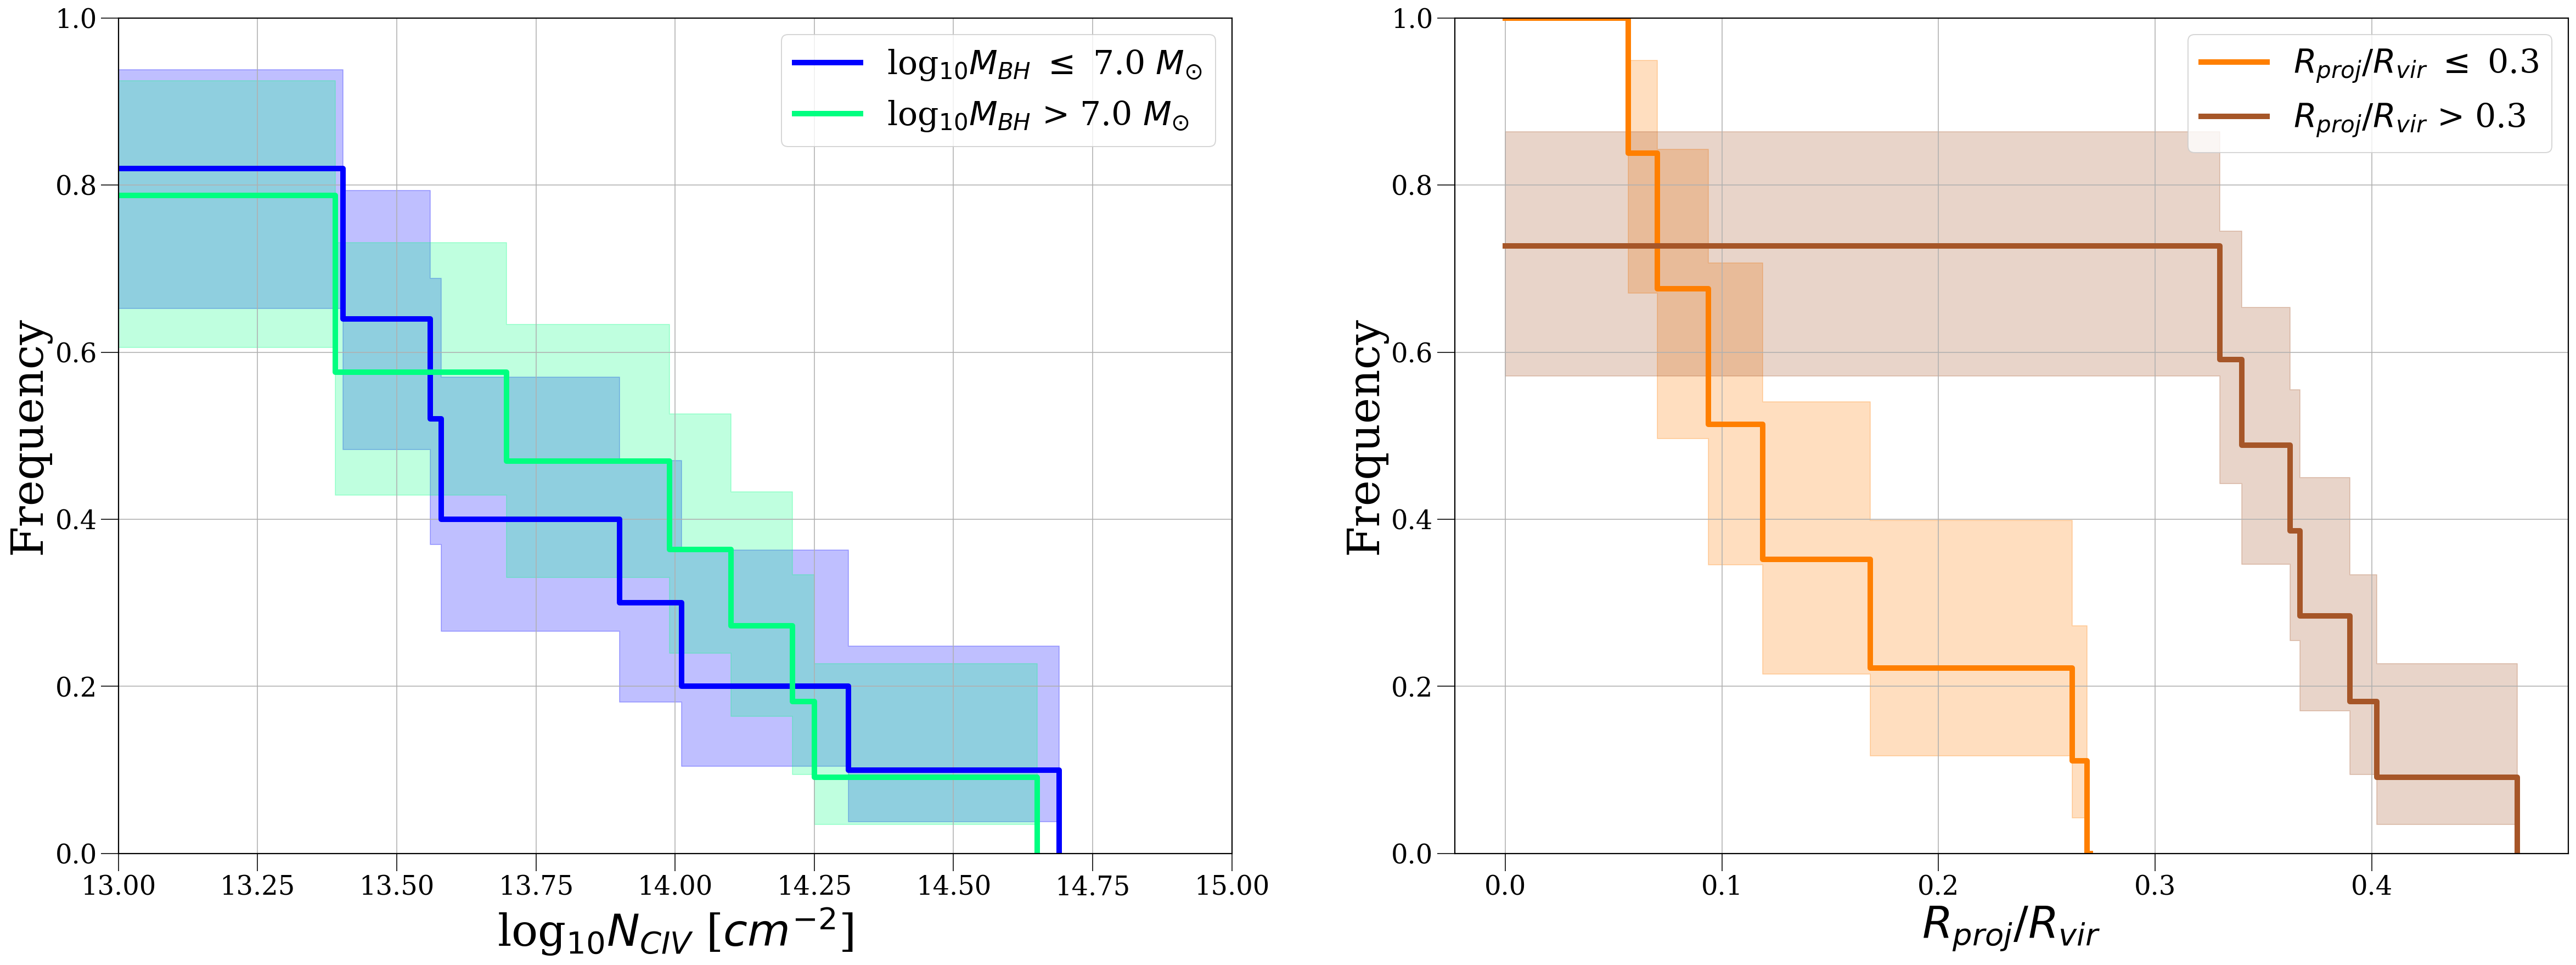

In [125]:
# Create the figure
fig, ax = plt.subplots(1,2, figsize=(40, 14))
#fig1.set_size_inches(24,7.5)
#fig1.patch.set_facecolor('white')

# Kaplan Meier plot - NCIV for different MBH sample
# Making/plotting a KM curve for low MBH sample data points 
plot_KM_lmbh(label=r"log$_{10}M_{BH}$ $\leq$ 7.0 $M_{\odot}$",
            c='#0000ff', ax=ax[0], lw = 5, column_density=False)

# Making/plotting a KM curve for highMBH sample data points
plot_KM_hmbh(label=r"log$_{10}M_{BH}$ > 7.0 $M_{\odot}$",
            c= '#00ff80', ax=ax[0], lw = 5, column_density=False)

ax[0].set_ylim(ymin=0, ymax=1)
ax[0].set_xlim(xmin=13, xmax=15)
ax[0].set_xlabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]")
ax[0].set_ylabel("Frequency")
ax[0].grid()
ax[0].legend(fontsize=30)
#ax[0].tick_params(axis='x', labelsize=25)
#ax[0].tick_params(axis='y', labelsize=25)


# Kaplan Meier plot - R/Rvir for different MBH sample 
# Making/plotting a KM curve for inner region <= 0.2
plot_KM_inner_rr(label=r"$R_{proj}/R_{vir}$ $\leq$ 0.3",
            c=CB_color_cycle[1], ax=ax[1], lw = 5, column_density=False)

# Making/plotting a KM curve for outer region > 0.2 
plot_KM_outer_rr(label=r"$R_{proj}/R_{vir}$ > 0.3",
            c= CB_color_cycle[4], ax=ax[1], lw = 5, column_density=False)

ax[1].set_xlabel(r'$R_{proj}/R_{vir}$')
ax[1].set_ylim(ymin=0, ymax=1)
ax[1].set_ylabel("Frequency")
ax[1].grid()
ax[1].legend(fontsize=30)
#ax[1].tick_params(axis='x', labelsize=25)
#ax[1].tick_params(axis='y', labelsize=25)
plt.show()

### Ben's idea for fit stuff 

In [86]:
#Fit for COS-Holes and literature data 

XX =  np.copy(coslit['Rproj/Rvir']) #Getting the impact parameter from my galaxy parameters table 
YY = np.copy(coslit["N"]) #getting the column density of CIV from main data table 
YY_err = np.copy(coslit["sigN"]) #column density error of CIV 
UL = np.copy(coslit['uplim']) #1 = det and 0= uplim 
has_UL = UL < 1 #determining the ones that have upper limts (in his table they are denoted with -1 in the error column) T/F

Ylim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)
Ylim[has_UL] = 1 #if this array has a -1 values (upper limit) then it is given the value of 1 
Xlim = np.zeros_like(XX, dtype = int) #Return an array of zeros with the same shape and type as the impact parameters (XX)

coeff = "kendallt" # the correlation coefficient 
Nboot = 10_000 #number of bootstrapping iterations over which the uncertainties are estimated 

xCrr = XX #same as XX => impact parameters 
yCrr = YY #same as YY => column densities 
yCrr_err = YY_err #same as YY_err => column density error 
xlimCrr = Xlim #array of 0s same length as XX or Xlim 
ylimCrr = Ylim #array od 0s and 1s same length as YY or Ylim (1 if it is an upper limit)

kwargs = {"return_dist":True}
res = pymccorrelation(xCrr, yCrr, xlim = xlimCrr, ylim = ylimCrr, coeff = coeff, Nboot = Nboot, **kwargs)

outCrr = {} #Where the stat information is stored 

outCrr["coeff_percentiles"] = res[0]
outCrr["p-value_percentiles"] = res[1]
outCrr["coeff_dist"] = res[2]
outCrr["p-value_dist"] = res[3]

mc_datarr = {
    "Ion":["CIV"]*len(outCrr["coeff_dist"]),
    r"Kendall's $\tau$":outCrr["coeff_dist"],
    r"$\log_{10}$(p-value)":np.log10(outCrr["p-value_dist"])
}

In [87]:
upper_lim_Crr = yCrr_err < 0 #a mask to find the upper limits for later stuff I think 

delta_Crr = np.invert(upper_lim_Crr) #array of True and False 
xsig_Crr = np.zeros_like(xCrr) #array of 0s like xC => like XX => the impact parameters bc they dont have error oh i see
ysig_Crr = yCrr_err[:] #error of the column densities 

lmcens_Crr = linmix.LinMix(xCrr, yCrr, xsig_Crr, ysig_Crr, delta=delta_Crr, K=2)
lmcens_Crr.run_mcmc(silent=True)

yints_Crr = lmcens_Crr.chain['alpha'] #same shape as the Nboot (looks like 12-14 values)
slopes_Crr = lmcens_Crr.chain['beta'] #same shape as the Nboot (looks like very very small values)

mean_yint_Crr = yints_Crr.mean() #mean alpha value (~14)
mean_slope_Crr = slopes_Crr.mean() #mean beta value (~ -0.010)

xxrr = np.linspace(0,0.5,100) #This is how long the line is gonna be
all_lines = np.array([m*xxrr + b for (m,b) in zip(slopes_Crr, yints_Crr)]) #makng the equation

lo_line, med_line, hi_line = np.percentile(all_lines, (16,50,84), axis = 0) #percentiles for stats knowledge
mean_line = mean_slope_Crr*xxrr + mean_yint_Crr #mean line equation

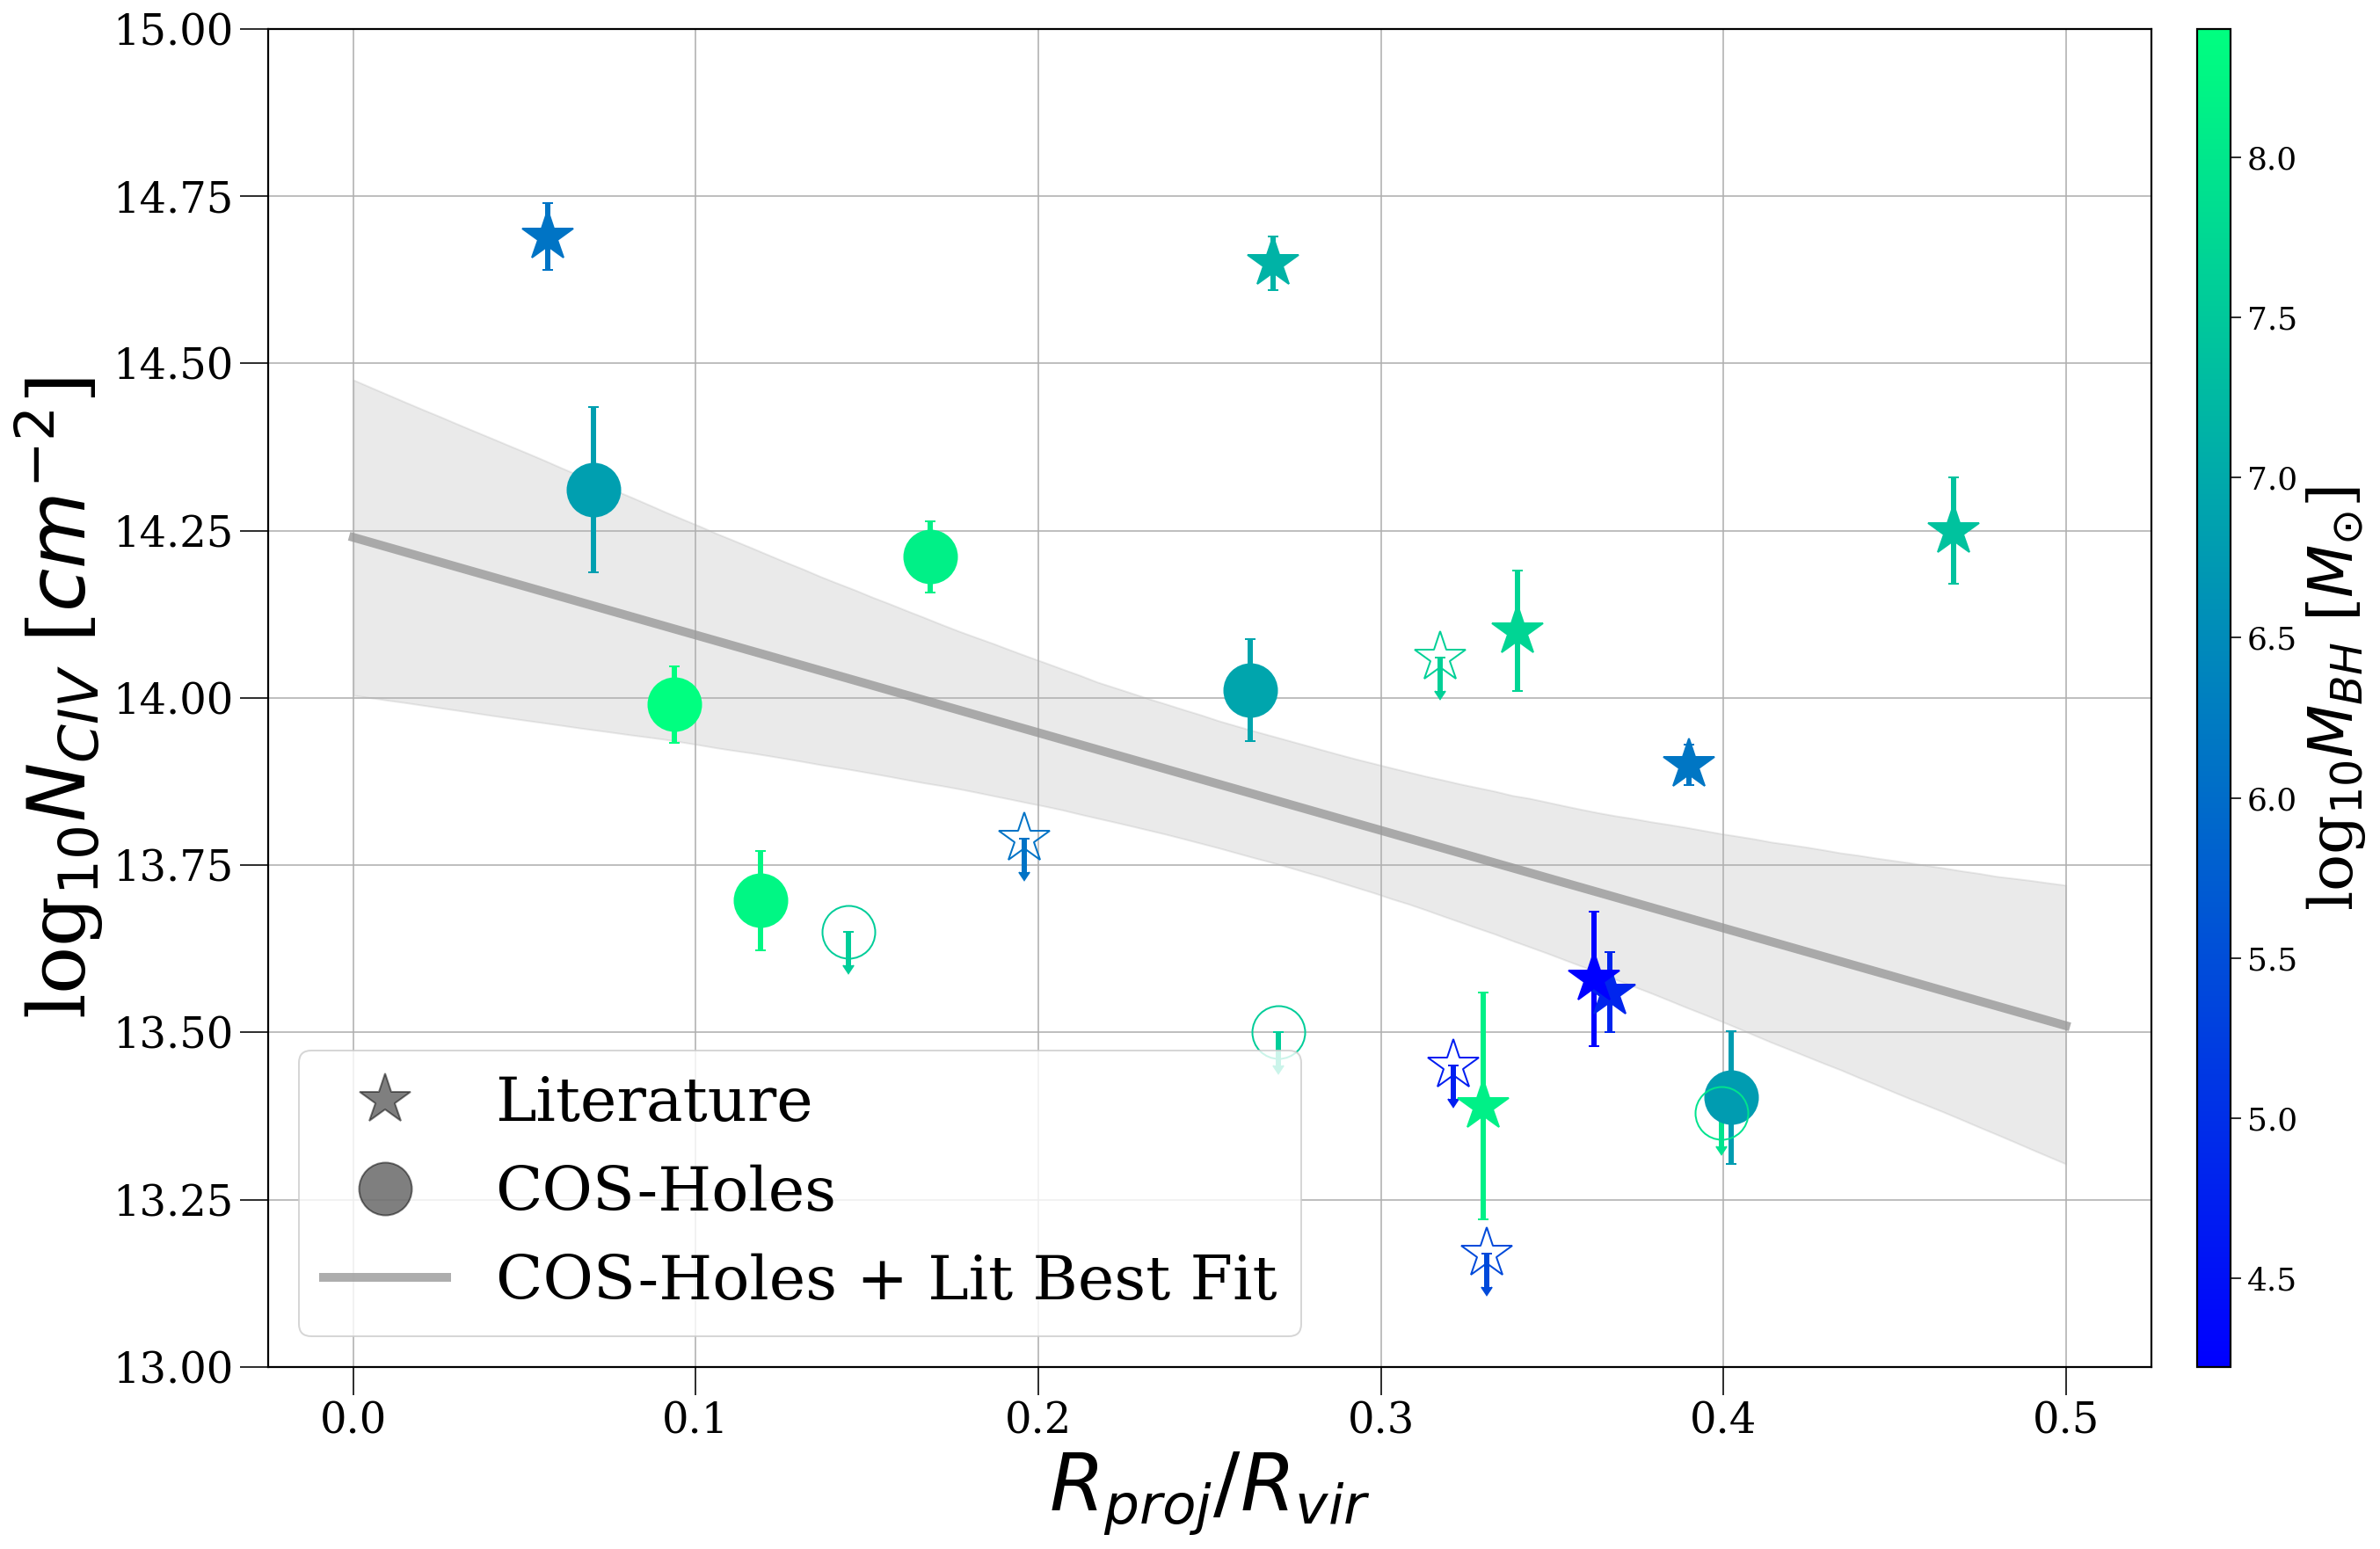

In [90]:
# Set figure size, I like this for 1 plot w colorbar but yaknow whateva
fig = plt.figure()

UL = np.array(coslit['uplim'])
has_UL = UL < 1

# Set a grid on your figure so you can define the color bar axis
axs = fig.add_gridspec(1, 50)

# Define the plot and the colorbar axes
plot = fig.add_subplot(axs[0, 0:48]) # this means use cols 0 - 49
cbar = fig.add_subplot(axs[0, 49])

# Now lets get the colors for ur points, luckily you have the values ...
# ... you want the colors to correspond to defined above as array 'c'
cool = plt.cm.get_cmap('winter')

#c = np.asarray(coslit['MBH'])
c = np.asarray(coslit['MBH'])
c_normed = (c-min(c))/(max(c)-min(c))
coloring = cool(c_normed) # you can replace plasma with whatev


# Okay now plotting, same as above but made the color our new defined one
# It gets mad at you without the loop cuz its dumb
r_arr = np.array(coslit['Rproj/Rvir'])
N_arr = np.array(coslit['N'])
sigN_arr = np.array(coslit['sigN'])
#sigmbh_arr = np.array(coslit['sigMBH'])
uplim_arr = np.array(coslit['uplim'])
marker_types = ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o','o', 
                '*', '*', '*', '*', 
               '*', '*', '*', '*', '*', 
               '*', '*',
               '*']


#need to have unassigned shapes to represent the 4 datasets but not have them show up on the plot 
plot.plot(0,0, c='k', marker='*', markersize=30, ls='none', label='Literature', alpha=0.5)
#plot.plot(0,0, c='k', marker='H', markersize=30, ls='none', label='Werk+13: COS-Halos', alpha=0.5)
#plot.plot(0,0, c='k', marker='d', markersize=30, ls='none', label='Borthakur+14: COS-Dwarfs', alpha=0.5)
#plot.plot(0,0, c='k', marker='p', markersize=30, ls='none', label='Lehner+20: Project AMIGA', alpha=0.5)
plot.plot(0,0, c='k', marker='o', markersize=30, ls='none', label='COS-Holes', alpha=0.5)

#All data fit 
plot.plot(xxrr, mean_line, color = CB_color_cycle[6], alpha = 0.8,lw = 5, ls = "-", label='COS-Holes + Lit Best Fit')
plot.fill_between(xxrr, lo_line, hi_line, color =CB_color_cycle[6], alpha = 0.2)


for i in range(len(r_arr)):
    if uplim_arr[i] < 1:  
        plot.errorbar(r_arr[i], N_arr[i], 
                yerr=sigN_arr[i],  
                capsize = 3, c=coloring[i], marker= marker_types[i], 
                markersize=30, ls='none', elinewidth=3, mfc='none', uplims=True)
    else: 
        plot.errorbar(r_arr[i], N_arr[i], 
                yerr=sigN_arr[i], 
                capsize = 3, c=coloring[i], marker=marker_types[i], 
                markersize=30, ls='none', elinewidth=3)
    
# I changed some of your sizes cause they looked too big with my code ig

# Here's where the magic happens
# Set up normalization for the color bar
# (sets lowest color to min value and highest color to max value)
norm = mpl.colors.Normalize(vmin=min(c), vmax=max(c))

# make the color bar
#cmap = mpl.colors.ListedColormap(coloring, name='Rproj/Rvir')

# !!!!! Use this instead to make the colorbar look continuous gradient:
cmap = cool

# mapping for the color bar
mapping = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# do the thing, telling it to use the subplot you created for the ...
# ... color bar (cax = cbar)
colorbar = fig.colorbar(mapping, cax=cbar, orientation='vertical')

# Okay now it's created, the rest is just visual preference:
colorbar.ax.tick_params(length=6, labelsize=18)
colorbar.ax.spines['top'].set_linewidth(1.5)
colorbar.ax.spines['bottom'].set_linewidth(1.5)
colorbar.ax.spines['left'].set_linewidth(1.5)
colorbar.ax.spines['right'].set_linewidth(1.5)
colorbar.set_label(label=r'log$_{10}M_{BH}$ [$M_{\odot}$]', size=35)

# Your other stylings from above:
plot.legend(loc=3, fontsize=35) # Theres no labels for your legend but ill leave it
plot.set_xlabel(r"$R_{proj}/R_{vir}$", fontsize=45)
plot.set_ylabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=45)
plot.set_ylim([13, 15])
#plot.set_xlim([4, 9])
plot.grid(True)
#plt.tight_layout()
plt.show()

In [112]:
print(f'y={np.round(mean_slope_Crr,3)}x + {np.round(mean_yint_Crr,3)}')
print('y = log$_{10}N_{CIV}$ [$cm^{-2}$]')
print('x = $R_{proj}/R_{vir}$')

y=-1.46x + 14.24
y = log$_{10}N_{CIV}$ [$cm^{-2}$]
x = $R_{proj}/R_{vir}$


In [ ]:
pd.set_option('display.max_rows', None)

In [91]:
#For the sum values 
mini_fit= {'rr': xxrr,
             'nciv': mean_line}
mini_fit = pd.DataFrame(data=mini_fit)
#mini_fit

In [92]:
fit_nciv = np.array([mini_fit['nciv'][80], mini_fit['nciv'][23], mini_fit['nciv'][14],
                    mini_fit['nciv'][19], mini_fit['nciv'][52], mini_fit['nciv'][33], 
                    mini_fit['nciv'][29], mini_fit['nciv'][54], mini_fit['nciv'][79], 
                    mini_fit['nciv'][39], mini_fit['nciv'][63], mini_fit['nciv'][53],
                    mini_fit['nciv'][93], mini_fit['nciv'][66], mini_fit['nciv'][64],
                    mini_fit['nciv'][73], mini_fit['nciv'][72], mini_fit['nciv'][11],
                    mini_fit['nciv'][68], mini_fit['nciv'][78], mini_fit['nciv'][66]])
#fit_nciv

In [93]:
delta_nciv = np.abs(np.asarray(coslit['N'])-fit_nciv)
#delta_nciv

In [94]:
noabs_delta_nciv = np.asarray(coslit['N'])-fit_nciv
#noabs_delta_nciv

In [95]:
mini_deltas = {'delta_nciv': delta_nciv,
              'noabs_delta_nciv': noabs_delta_nciv}
mini_deltas = pd.DataFrame(data=mini_deltas)

In [124]:
deltas_coslit = pd.concat([coslit.reset_index(drop=True), mini_deltas], axis=1)
#deltas_coslit

In [100]:
#Splitting COSlit sample up so that I can make the fits for each 
coslit_low_delta = deltas_coslit.loc[(deltas_coslit['MBH'] <= 7)]
coslit_high_delta = deltas_coslit.loc[(deltas_coslit['MBH'] > 7)]

In [102]:
#Got this code from Jess which this is from CGM^2 stuff I think.... 
    #Need to get more information about this for when/if we include in the paper 

# Defining functions for plotting
def plot_KM_lmbh_noabs_deltanciv(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32)

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_low_delta['noabs_delta_nciv'] # List of col densities
    Y = coslit_low_delta['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)
    
    
# Defining functions for plotting
def plot_KM_hmbh_noabs_deltanciv(label, c, ax, lw, column_density=False):
    # Create semi-transparent Kaplan Meier object
    kmf = KaplanMeierFitter(alpha=0.32)

    # Select galaxies within rho/rvir limit
    #df = df#[df['rho_rvir'] < max_rhorvir] #I don't need the limit stuff 
    X = coslit_high_delta['noabs_delta_nciv'] # List of col densities
    Y = coslit_high_delta['uplim'] # List of (non)detections, 0 for nondetect, 1 for detect

    # Calculates the Kaplan-Meier curve
    kmf.fit_left_censoring(X, event_observed=Y, label=label)
    # Plots the Kaplan-Meier curve on axis ax with color c
    kmf.plot(ax=ax, color=c, lw=lw)

/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,
/Users/samgarza/opt/anaconda3/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:446: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  DeprecationWarning,


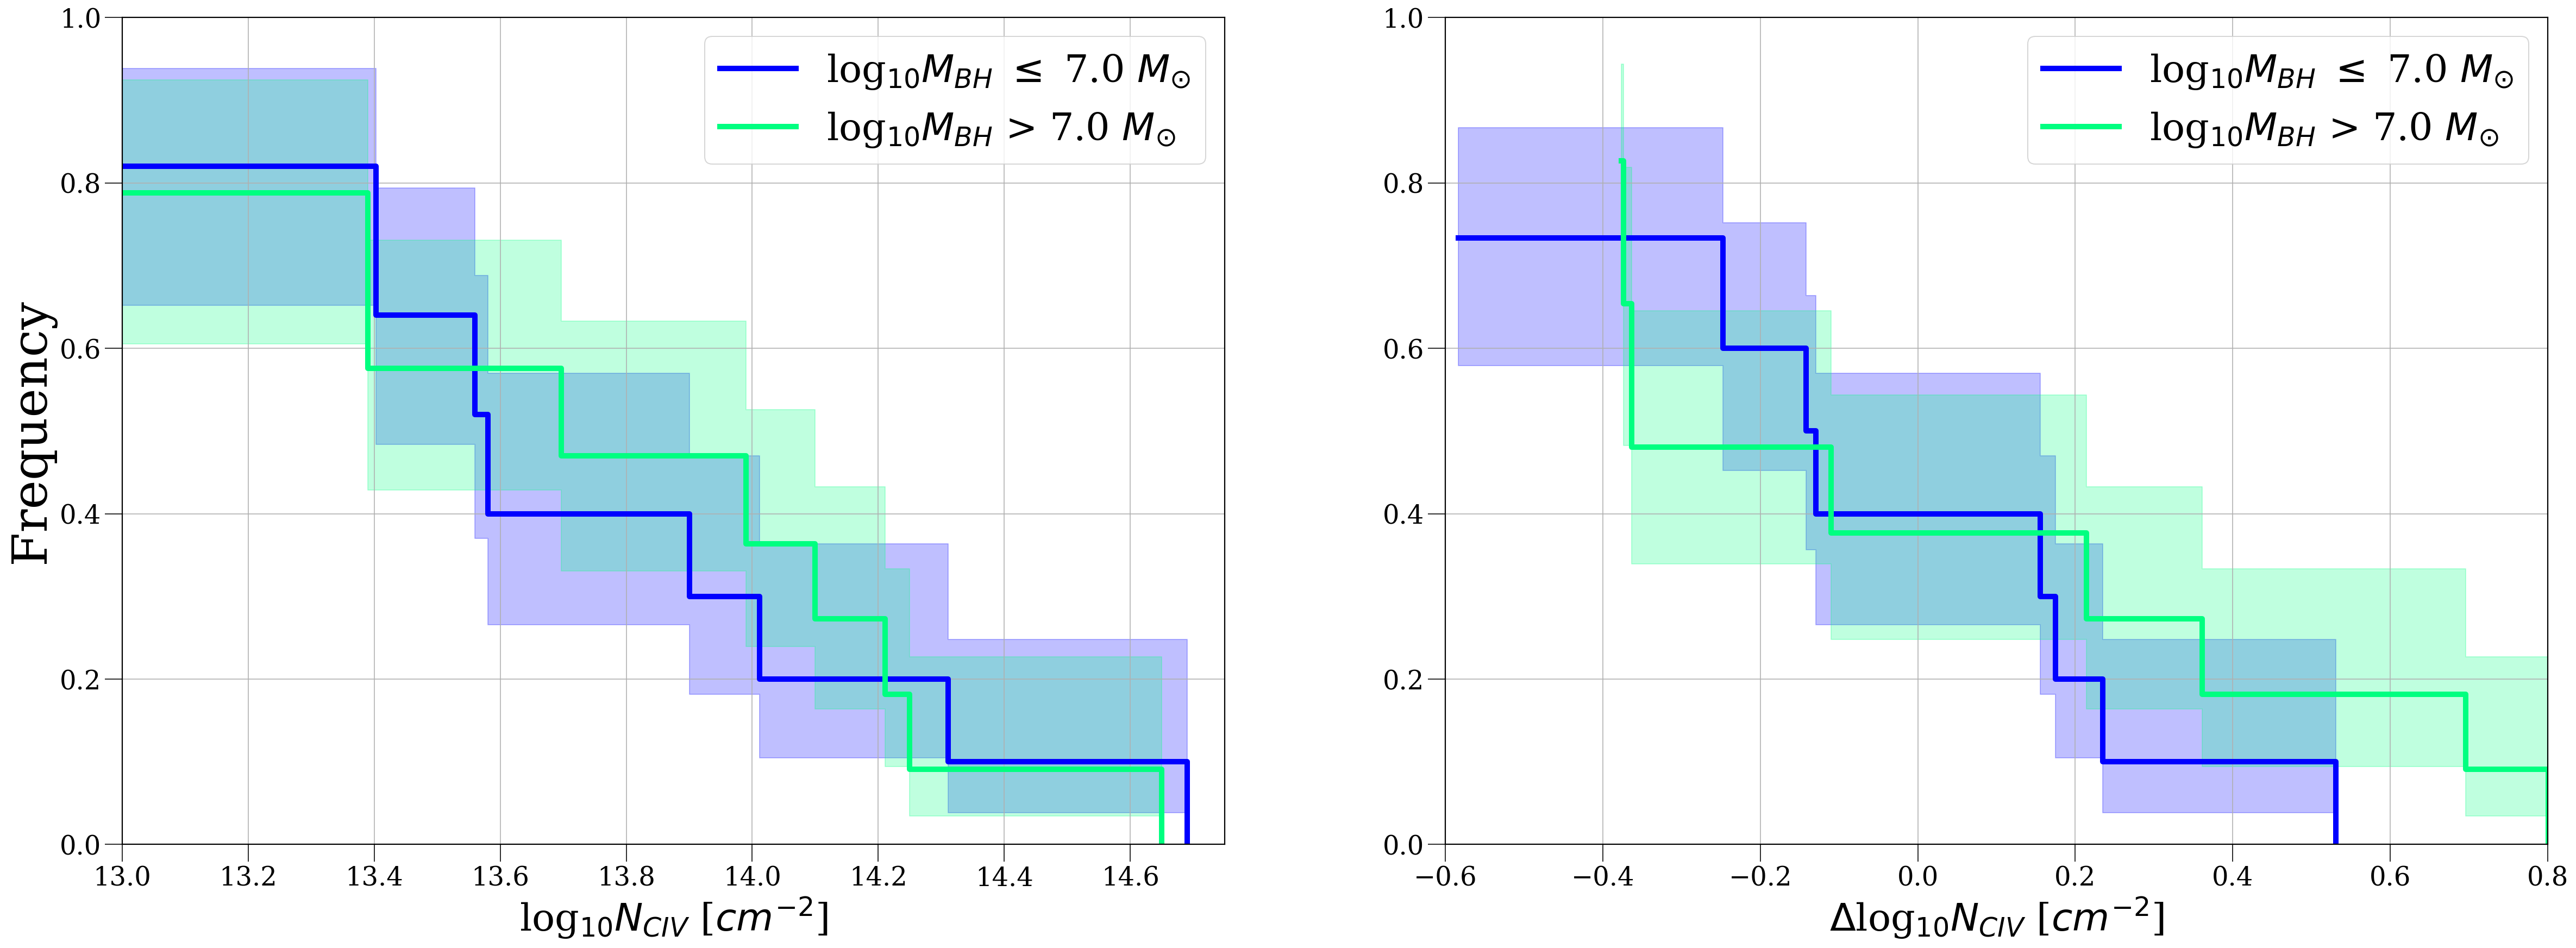

In [133]:
# Create the figure
fig, ax = plt.subplots(1,2, figsize=(40, 14))
#fig1.set_size_inches(24,7.5)
#fig1.patch.set_facecolor('white')

# Kaplan Meier plot - NCIV for different MBH sample
# Making/plotting a KM curve for low MBH sample data points 
plot_KM_lmbh(label=r"log$_{10}M_{BH}$ $\leq$ 7.0 $M_{\odot}$",
            c='#0000ff', ax=ax[0], lw = 5, column_density=False)

# Making/plotting a KM curve for highMBH sample data points
plot_KM_hmbh(label=r"log$_{10}M_{BH}$ > 7.0 $M_{\odot}$",
            c= '#00ff80', ax=ax[0], lw = 5, column_density=False)

ax[0].set_ylim(ymin=0, ymax=1)
ax[0].set_xlim(xmin=13, xmax=14.75)
ax[0].set_xlabel(r"log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=35)
ax[0].set_ylabel("Frequency", fontsize=45)
ax[0].grid()
ax[0].legend(fontsize=35)
#ax[0].tick_params(axis='x', labelsize=25)
#ax[0].tick_params(axis='y', labelsize=25)


# Kaplan Meier plot - R/Rvir for different MBH sample 
# Making/plotting a KM curve for inner region <= 0.2
plot_KM_lmbh_noabs_deltanciv(label=r"log$_{10}M_{BH}$ $\leq$ 7.0 $M_{\odot}$",
            c='#0000ff', ax=ax[1], lw = 5, column_density=False)

# Making/plotting a KM curve for outer region > 0.2 
plot_KM_hmbh_noabs_deltanciv(label=r"log$_{10}M_{BH}$ > 7.0 $M_{\odot}$",
            c= '#00ff80', ax=ax[1], lw = 5, column_density=False)

ax[1].set_xlabel(r"$\Delta$log$_{10}N_{CIV}$ [$cm^{-2}$]", fontsize=35)
ax[1].set_ylim(ymin=0, ymax=1)
ax[1].set_xlim(xmin=-0.6, xmax=0.8)
#ax[1].set_ylabel("Frequency")
ax[1].grid()
ax[1].legend(fontsize=35)
#ax[1].tick_params(axis='x', labelsize=25)
#ax[1].tick_params(axis='y', labelsize=25)
plt.show()